# <u>Data-driven control simulation and experimentation</u>
This document consolidates all code to plot the behavior in simulation and experimentation.

# 1. Usefull for code

## 1.1 Imports


In [9]:
# Importing necessary libraries

# Numpy for numerical operations
import numpy as np

# Matplotlib for plotting graphs
import matplotlib.pyplot as plt

# Scipy's integration function
from scipy.integrate import quad

# Scipy's optimization functions
from scipy.optimize import minimize

# Control library for control system functions
import control as ctrl

# Scipy's linear algebra solver
from scipy.linalg import solve

# Scipy's pole placement function
from scipy.signal import place_poles

# Scipy's statistical functions
from scipy import stats

# Pandas for data manipulation and analysis
import pandas as pd

# Seaborn for advanced statistical data visualization
import seaborn as sns

# Scipy's continuous to discrete conversion
from scipy.signal import cont2discrete

# Matplotlib's function formatter
from matplotlib.ticker import FuncFormatter

# Warnings library to suppress specific warning categories
import warnings

# Suppress specific warning categories, in this case, FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Create a colormap that transitions from light to dark
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Creating custom legend handles
import matplotlib.lines as mlines

## 1.2 For plotting

In [16]:
# List of color schemes to use
colors2 = ['Oranges', 'Blues', 'Greens']

# Function to create a gradient of colors
def get_color_gradient(base_color, n):
    # Create a color map from the base color
    base_color = np.array(plt.get_cmap(base_color)(range(256)))
    color_map = LinearSegmentedColormap.from_list('custom_gradient', base_color)
    # Generate and return a list of n colors from the color map
    return [color_map(i) for i in np.linspace(0.3, 0.9, n)]

# Function to convert a string to a complex number
def str_to_complex(s):
    # Check if the string contains 'i'
    if 'i' in str(s):
        # Replace 'i' with 'j' for complex conversion
        return complex(s.replace('i', 'j'))
    else:
        # Convert to float then to complex
        return complex(float(s), 0)

# 2. Mathematical model


## 2.1 Mechanical model

In [6]:
# Parameters from Balboa

# Mass and inertia parameters
mp = 0.316  # Body part mass [kg]
mw = 2 * 0.021  # Total mass of both wheels [kg]
l = 23.0 * 1e-3  # Position of center of mass (COM) [m]

Ip = 444.43 * 1e-6  # Inertia of body part [kg*m^2]
Iw = 2 * 26.89 * 1e-6  # Total inertia of both wheels [kg*m^2]

# Physical constants
r = 40 * 1e-3  # Radius of wheel [m]
g = 9.81  # Gravity [m/s^2]

# Weighting matrices
E = np.array([
    [Iw + (mw + mp) * r**2, mp * r * l],
    [mp * r * l, Ip + mp * l**2]
])  # Matrix for second derivatives (d^2/dt^2) of phi and theta

F = np.array([
    [0],
    [-mp * g * l]
])  # Matrix for theta

G = np.array([
    [1],
    [0]
])  # Matrix for input torque

# State-space representation of the system
# State variables: phi, theta, d(phi)/dt, d(theta)/dt
A = np.vstack([
    np.hstack([np.zeros((2, 2)), np.eye(2)]),
    np.hstack([np.zeros((2, 1)), -solve(E, F), np.zeros((2, 2))])
])  # System matrix

B = np.vstack([
    np.zeros((2, 1)),
    solve(E, G)
])  # Input matrix

C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])  # Output matrix

D = np.array([
    [0],
    [0],
    [0],
    [0]
])  # Feedforward matrix

# Create the state-space system
sys1 = ctrl.ss(A, B, C, D)

## 2.2 Electrical model

In [7]:
# Define constants
a = 7.5
b = 0.09
c = 0.4

# Create modified copies of A and B matrices
A_prime = A.copy()  # Copy of the system matrix A
B_prime = B / a     # Scaled input matrix B

# Define sampling time (Ts) - assuming Ts is defined earlier in the notebook
Ts = 0.01  # Example value, adjust as necessary

# Convert continuous system to discrete system using Zero-Order Hold (ZOH) method
A_dt, B_dt, _, _, _ = cont2discrete((A_prime, B_prime, C, D), Ts, method='zoh')


# 3. Numerical simulation


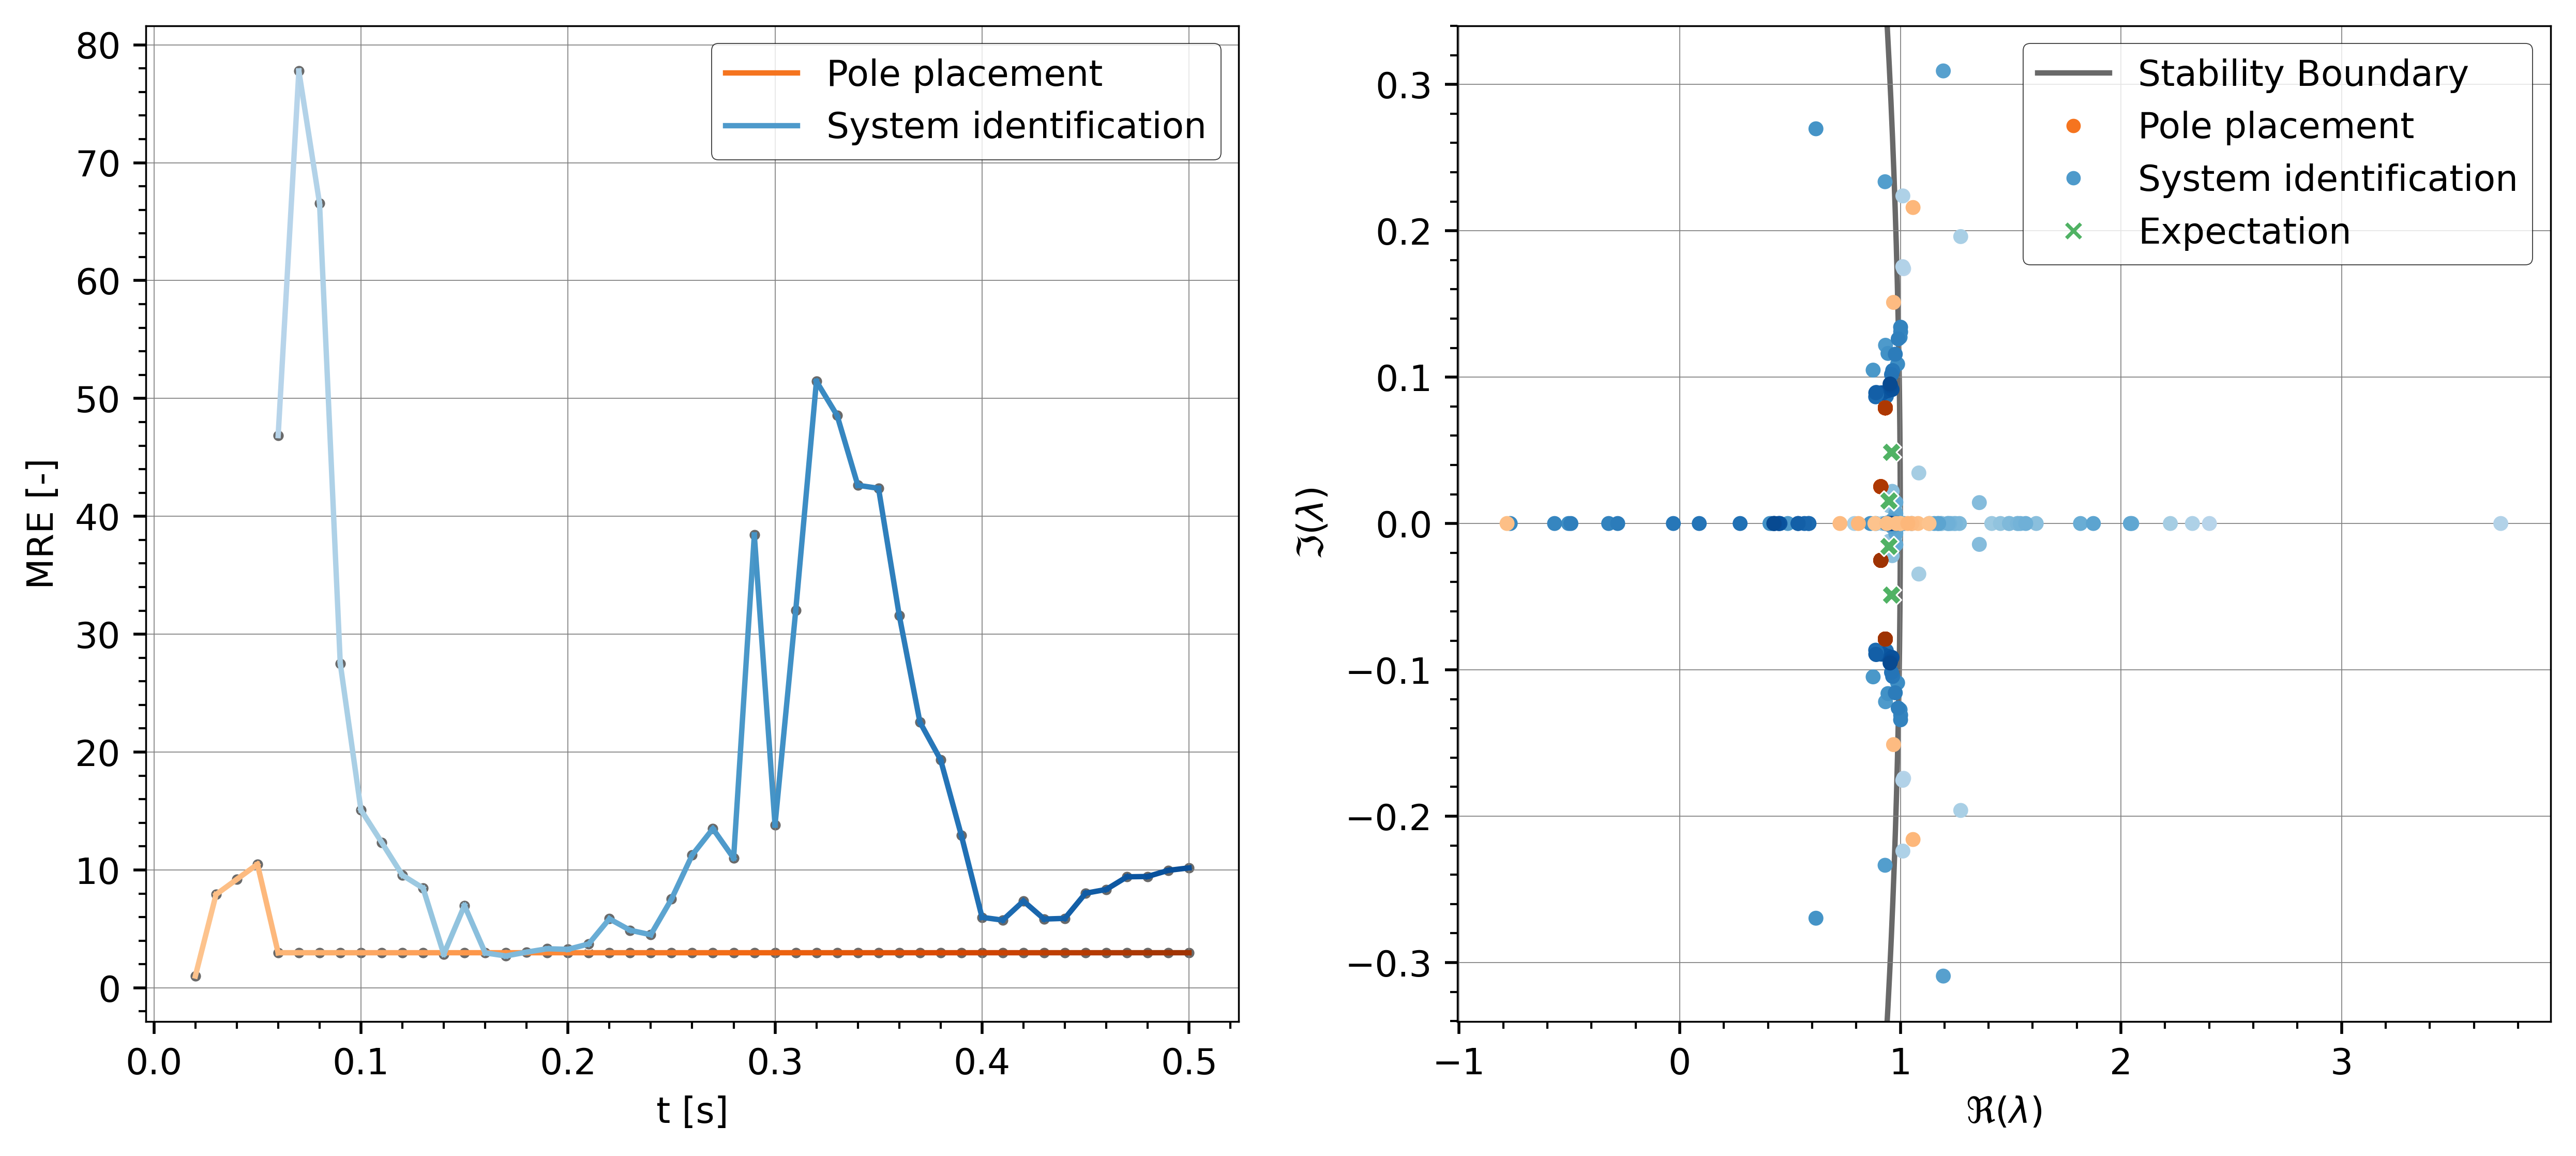

In [18]:
# Load data from CSV files
data1 = pd.read_csv('DDSimulation/DataForPlot/NoExcitementVariable1.csv')
data2 = pd.read_csv('DDSimulation/DataForPlot/NoExcitementVariable2.csv')

# Extract x and y values
x1 = data1['T_values']
y1 = data1['eig_diff1_values']

x2 = data2['T_values']
y2 = data2['eig_diff2_values']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)

gradient_colors = get_color_gradient(colors2[0], len(x1))
for j in range(len(x1)):
    ax1.plot(x1[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x1, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x2))
for j in range(len(x2)):
    ax1.plot(x2[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x2, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('t [s]')
ax1.set_ylabel('MRE [-]')
#ax1.legend()

# Load data from CSV files
data1 = pd.read_csv('DDSimulation/DataForPlot/NoExcitementVarPolePlot1.csv')
data2 = pd.read_csv('DDSimulation/DataForPlot/NoExcitementVarPolePlot2.csv')

# Extract x and y values
x1 = data1['x']
y1 = [data1['p1'].apply(str_to_complex), data1['p2'].apply(str_to_complex), data1['p3'].apply(str_to_complex), data1['p4'].apply(str_to_complex)]

x2 = data2['x']
y2 = [data2['p1'].apply(str_to_complex), data2['p2'].apply(str_to_complex), data2['p3'].apply(str_to_complex), data2['p4'].apply(str_to_complex)]

# Limit to top maxData values
maxData = 45
x1 = x1[:maxData]
y1 = [y[:maxData] for y in y1]

x2 = x2[:maxData]
y2 = [y[:maxData] for y in y2]

# Desired poles
tsdesired = 1
poles_bessel = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j])/tsdesired
poles_bessel = np.exp(0.01*poles_bessel)

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], maxData)
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], maxData)
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=2, color=gradient_colors, marker="o", s=10)

sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')
#ax2.legend()

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper right')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper right')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi/2, np.pi/2, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)


#plt.tight_layout()
plt.savefig("plot/TimeNoExcitement.png", bbox_inches='tight')  
plt.show()

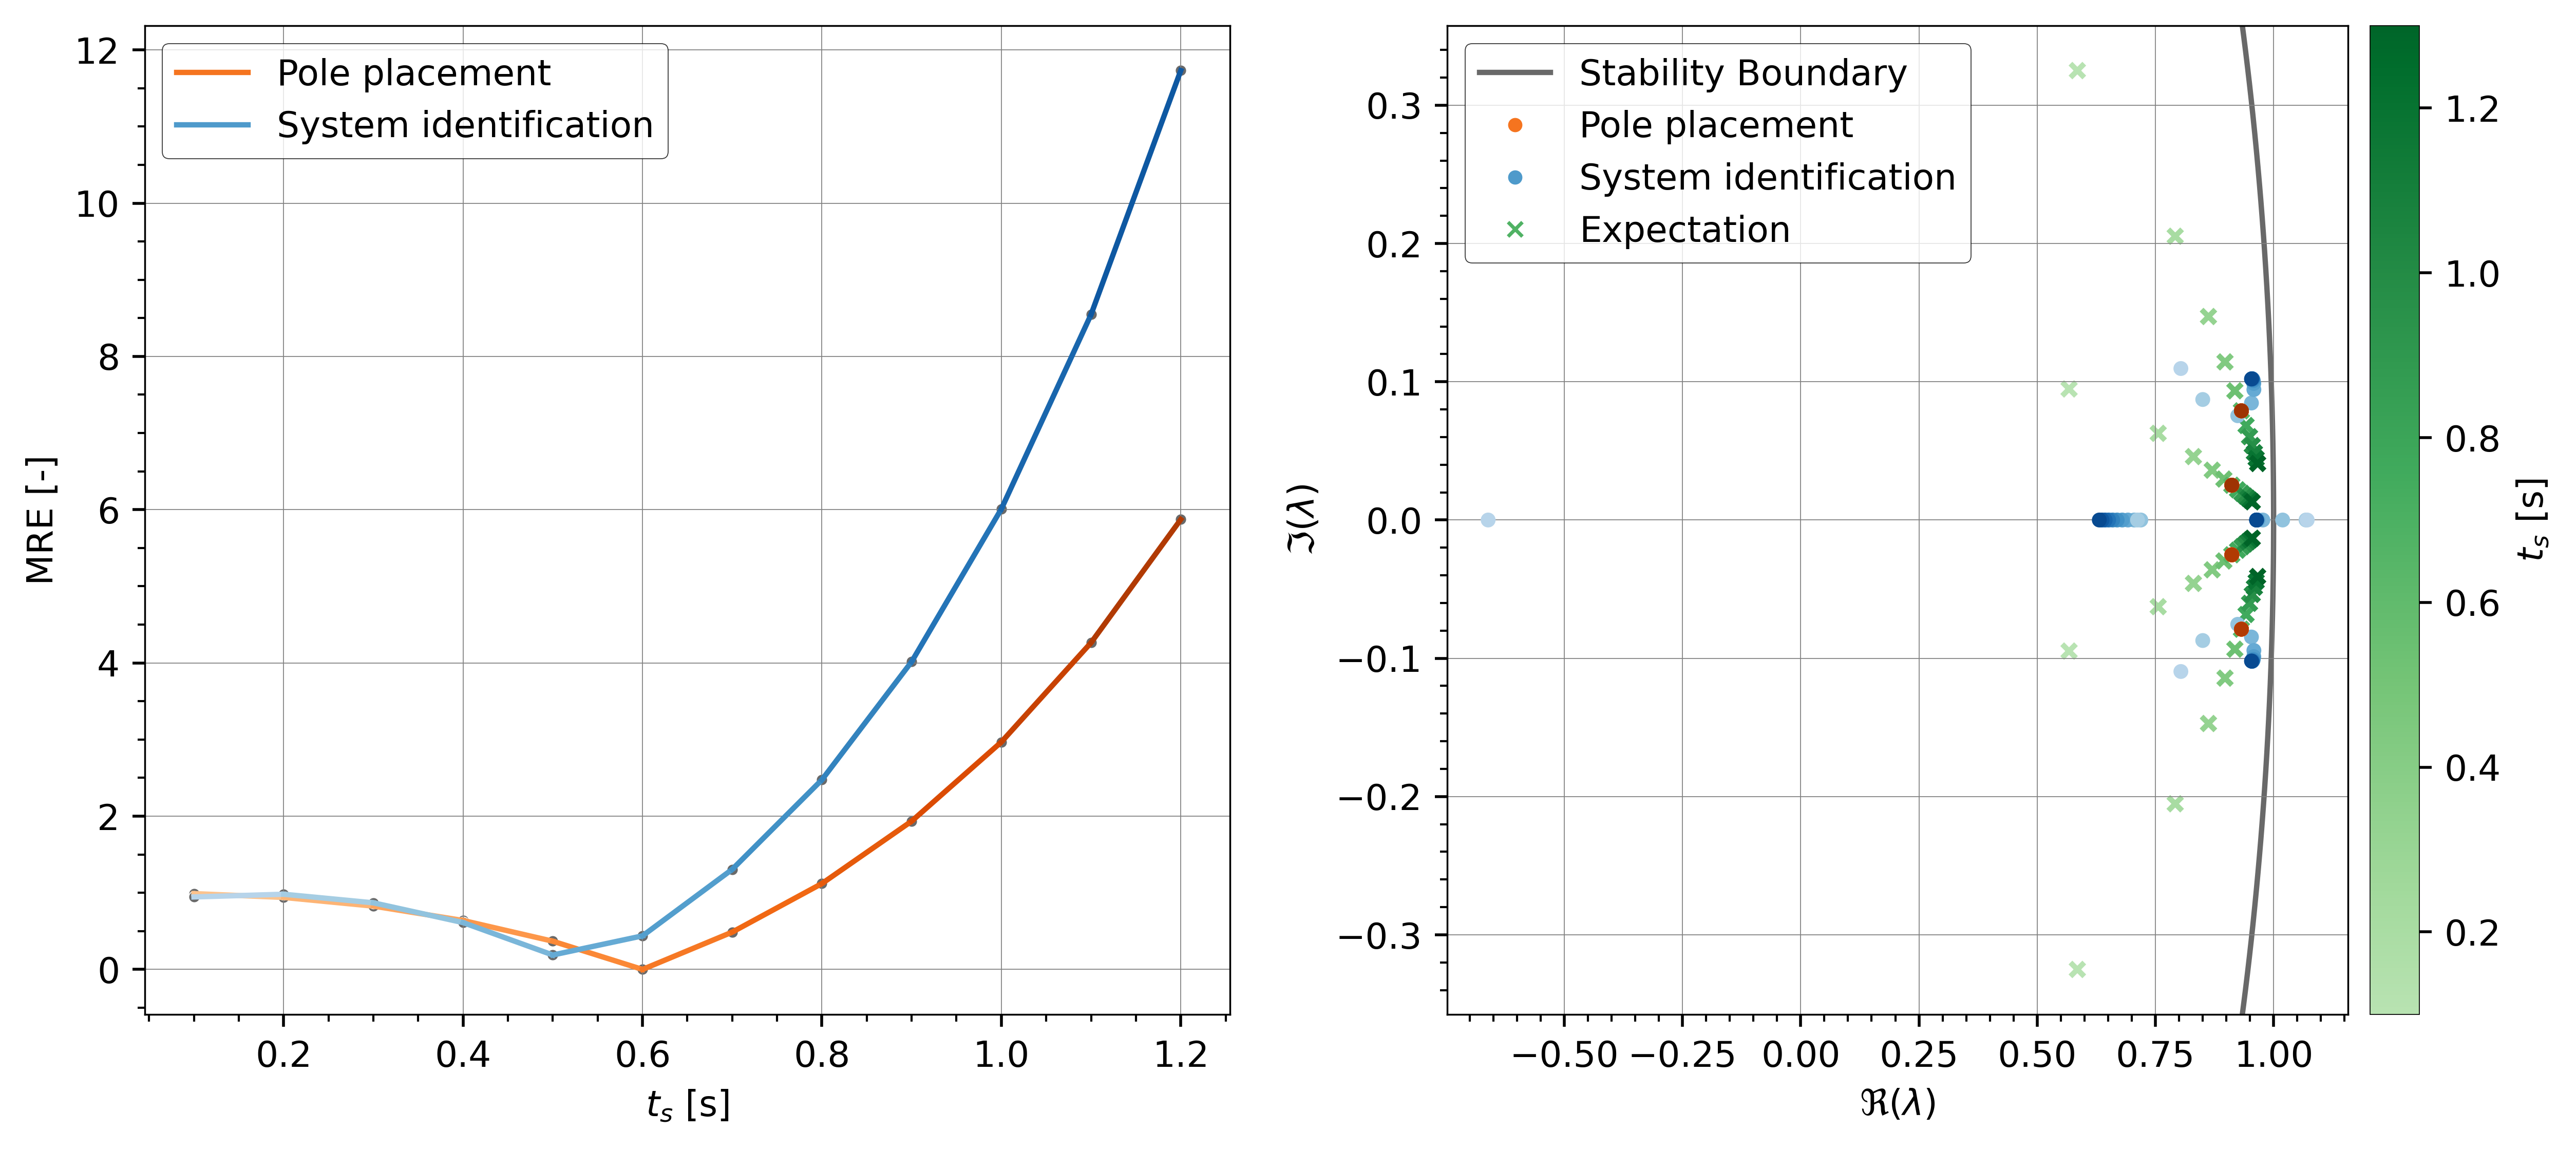

In [19]:
# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/NoExcitementPoles.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
poles_bessel = np.zeros((4, len(x)), dtype=complex)

for i in range(len(x)):
    # Desired poles
    tsdesired = x[i]
    pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
    poles_bessel[:, i] = np.exp(0.01 * pole)

for i in range(4):
    gradient_colors = get_color_gradient(colors2[2], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(poles_bessel[i]), np.imag(poles_bessel[i]), color=gradient_colors, marker="x", s=15)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('$t_s$ [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/NoExcitementPolesPlot.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Add a colorbar to the second plot
sm = plt.cm.ScalarMappable(cmap=LinearSegmentedColormap.from_list('custom_gradient', np.array(plt.get_cmap(colors2[2])(range(int(256*0.3),int(256*0.9))))), norm=Normalize(vmin=0.1, vmax=1.3))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2, orientation='vertical', pad=0.02)
cbar.set_label('$t_s$ [s]')
# Customize the colorbar's outline properties
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(0.25)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper left')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper left')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/distNoExcitement.png", bbox_inches='tight')  
plt.show()

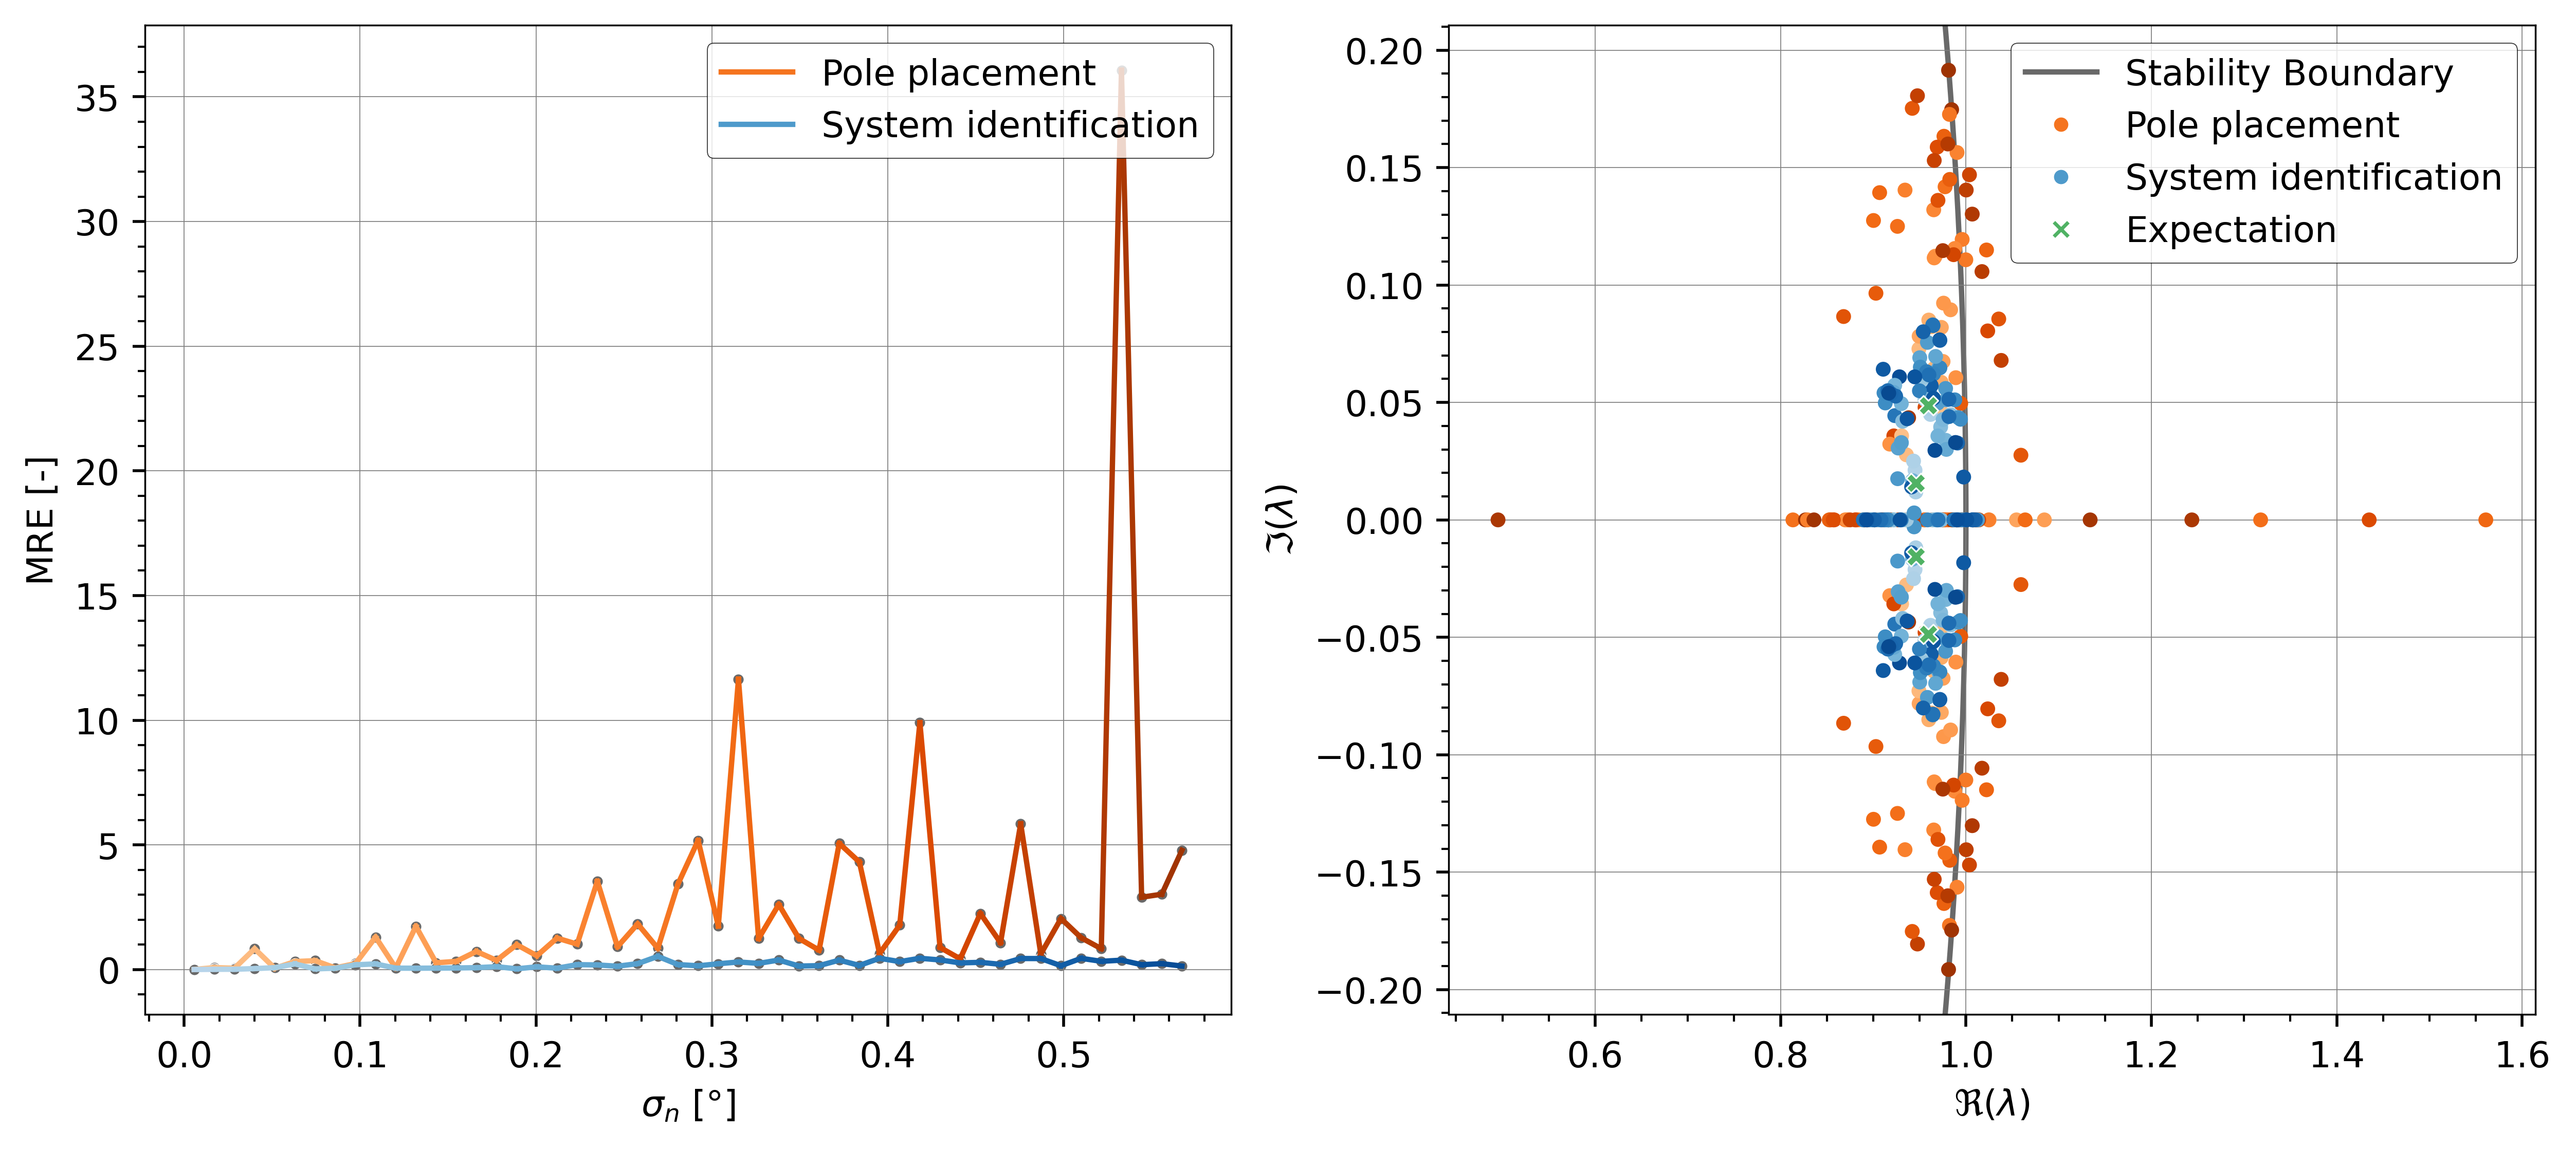

In [20]:
# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/WithExcitementNoise.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
tsdesired = 1
pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
poles_bessel = np.exp(0.01 * pole)
sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('$\sigma_n$ [°]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/WithExcitementNoisePlot.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper right')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper right')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/NoiseExcitement.png", bbox_inches='tight')  
plt.show()

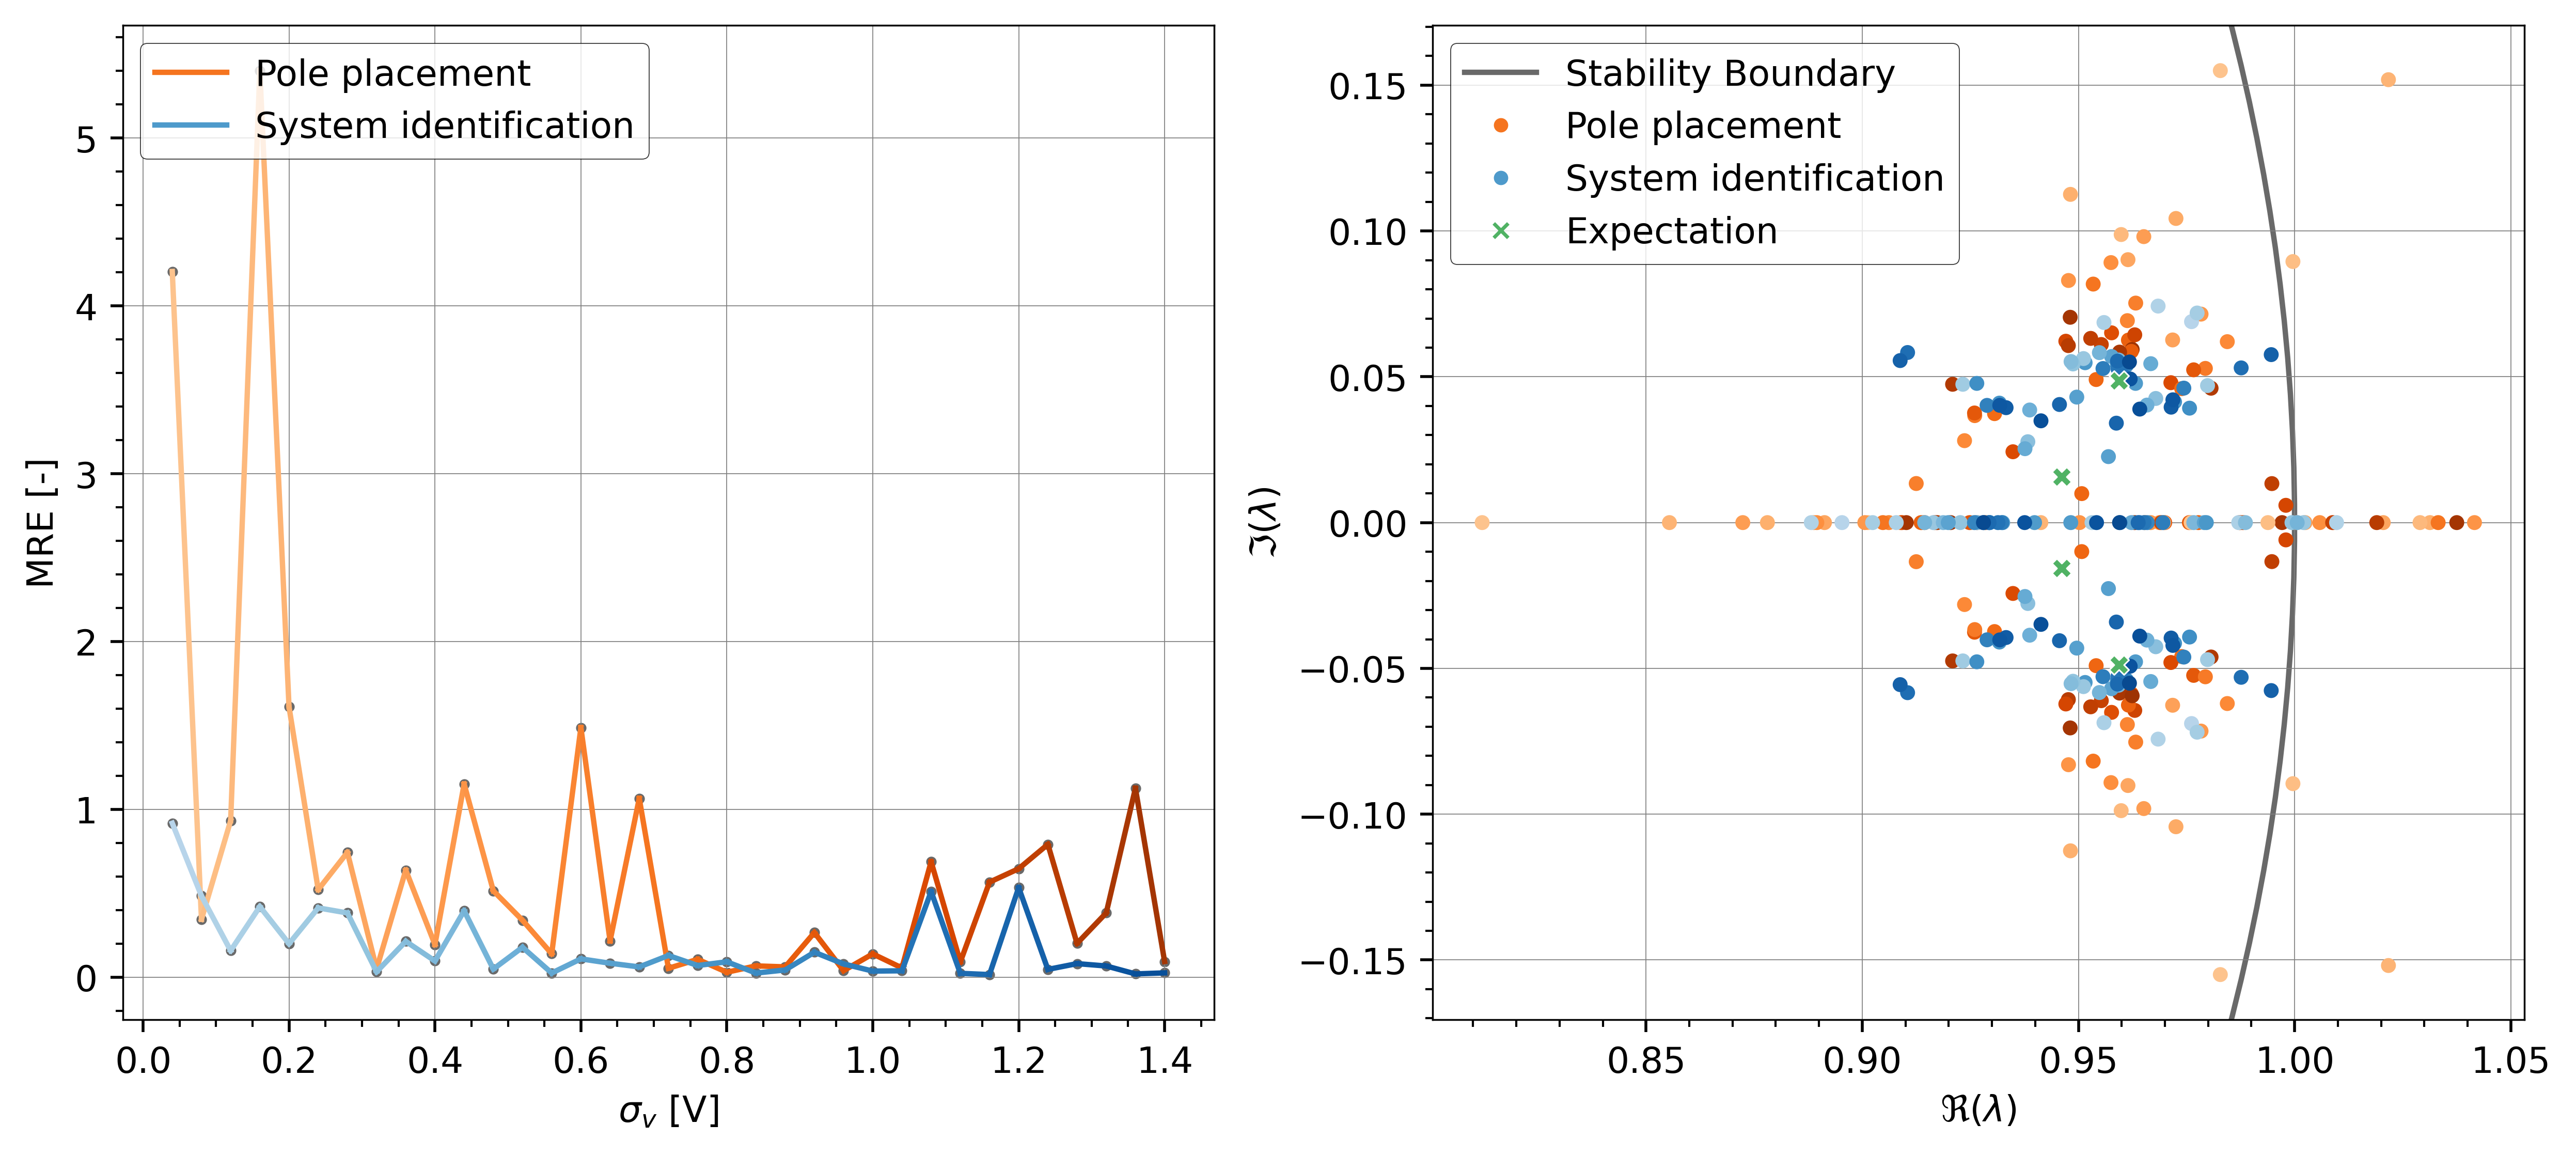

In [21]:
# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/WithExcitementPoles.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
tsdesired = 1
pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
poles_bessel = np.exp(0.01 * pole)
sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('$\sigma_v$ [V]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/WithExcitementPolesPlot.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper left')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper left')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/ExcitementAnalysis.png", bbox_inches='tight')  
plt.show()

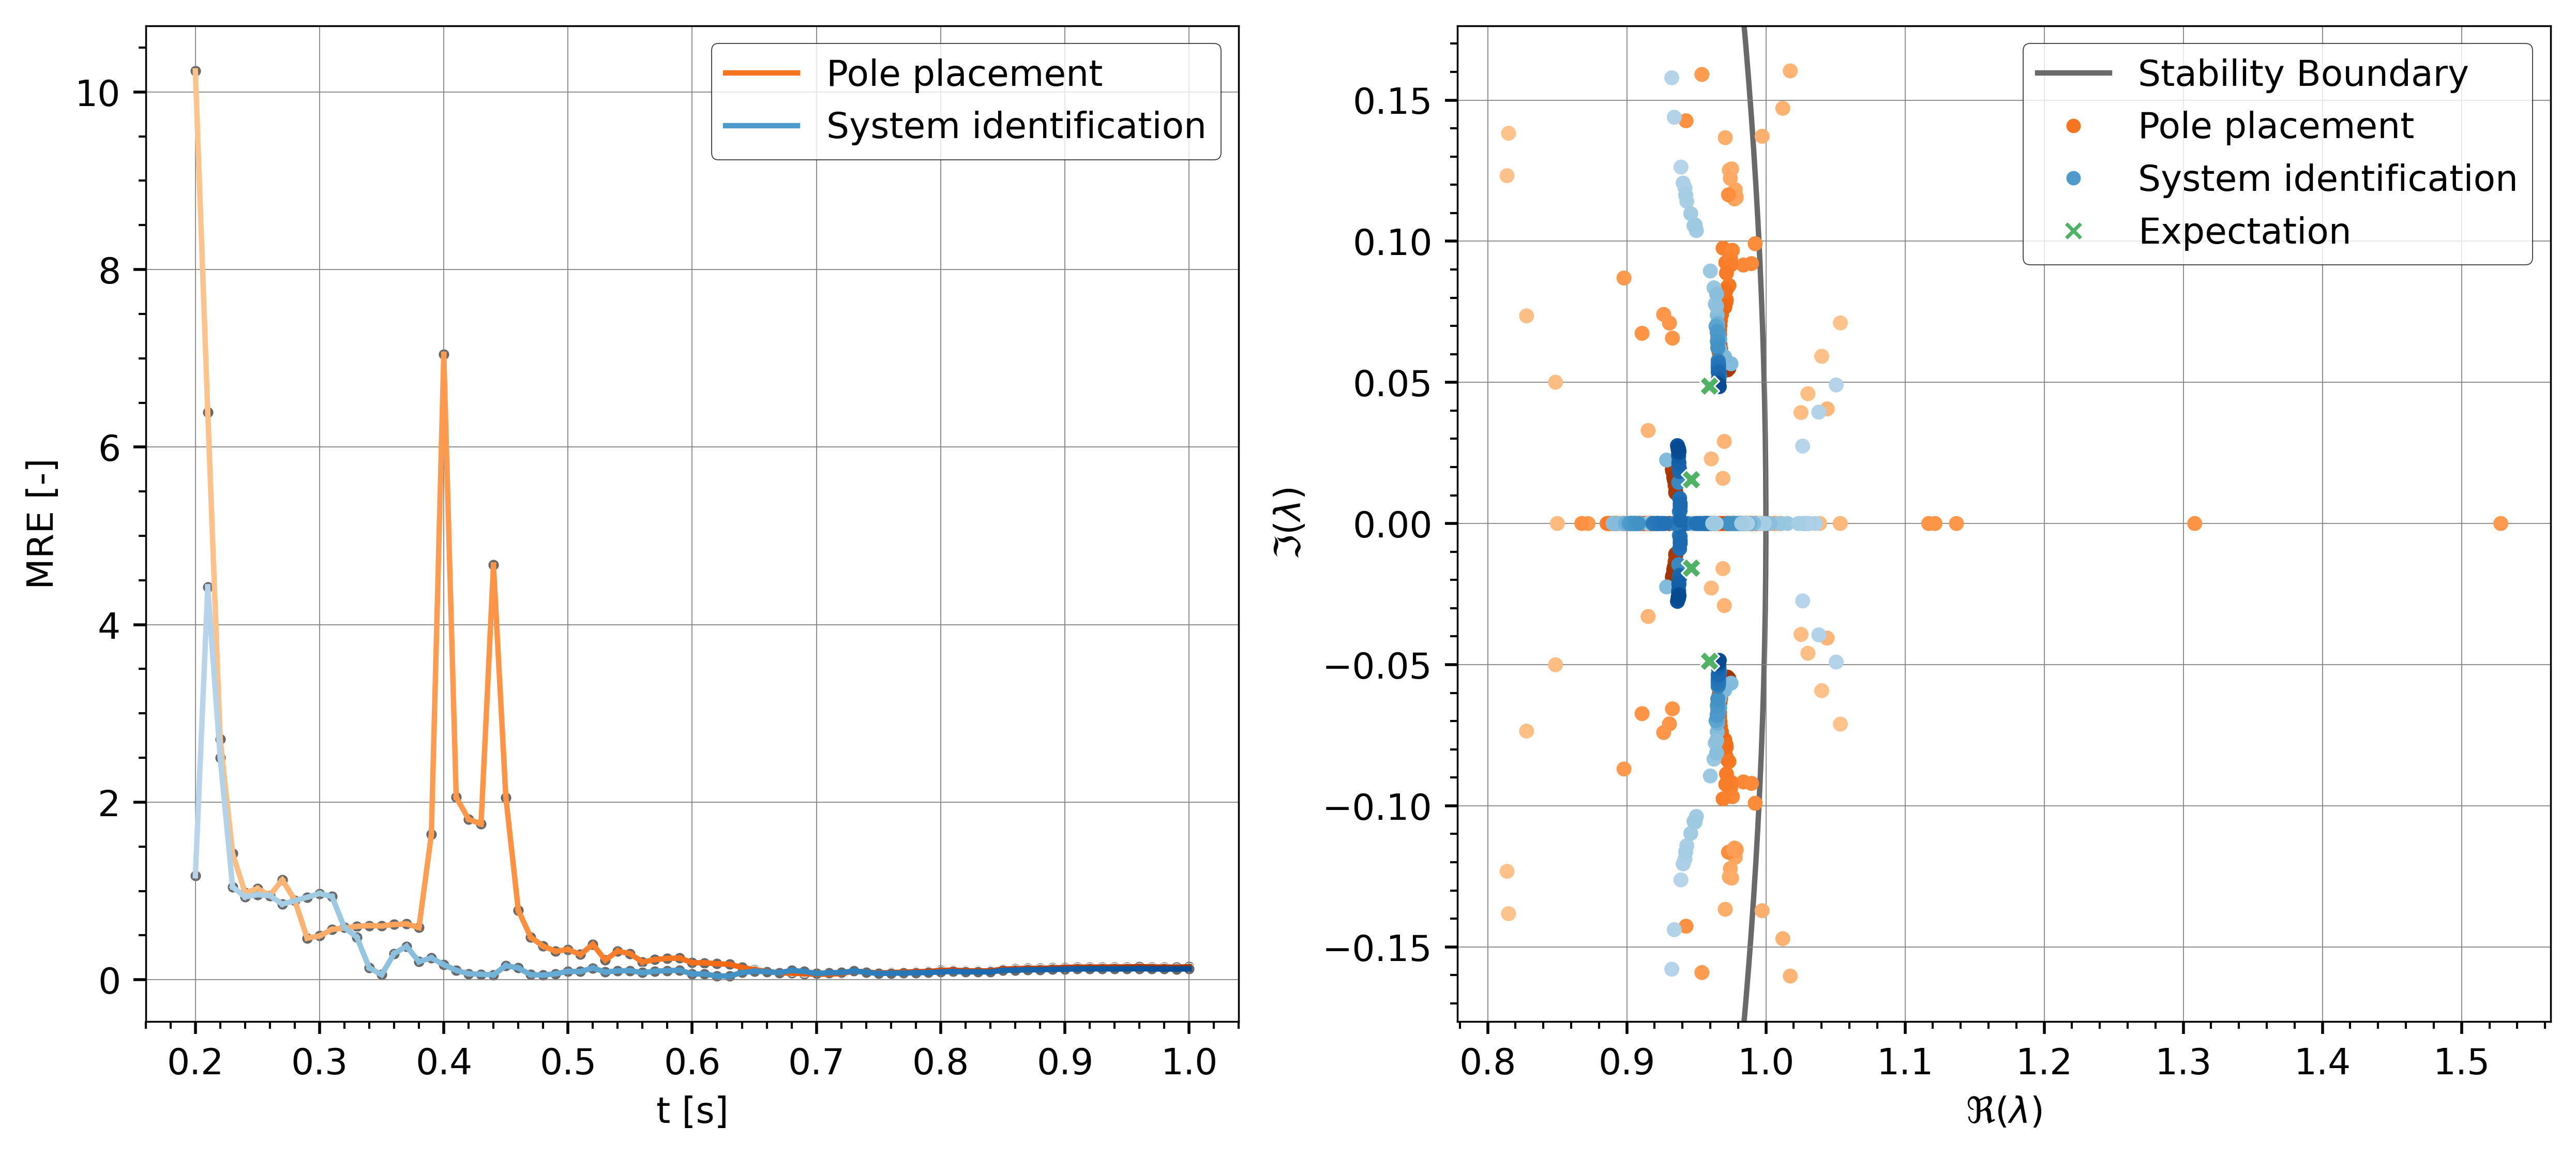

In [22]:
# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/WithExcitementVariable.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
tsdesired = 1
pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
poles_bessel = np.exp(0.01 * pole)
sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('t [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/WithExcitementVariablePlot.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper right')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper right')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/TimeExcitement.png", bbox_inches='tight')  
plt.show()

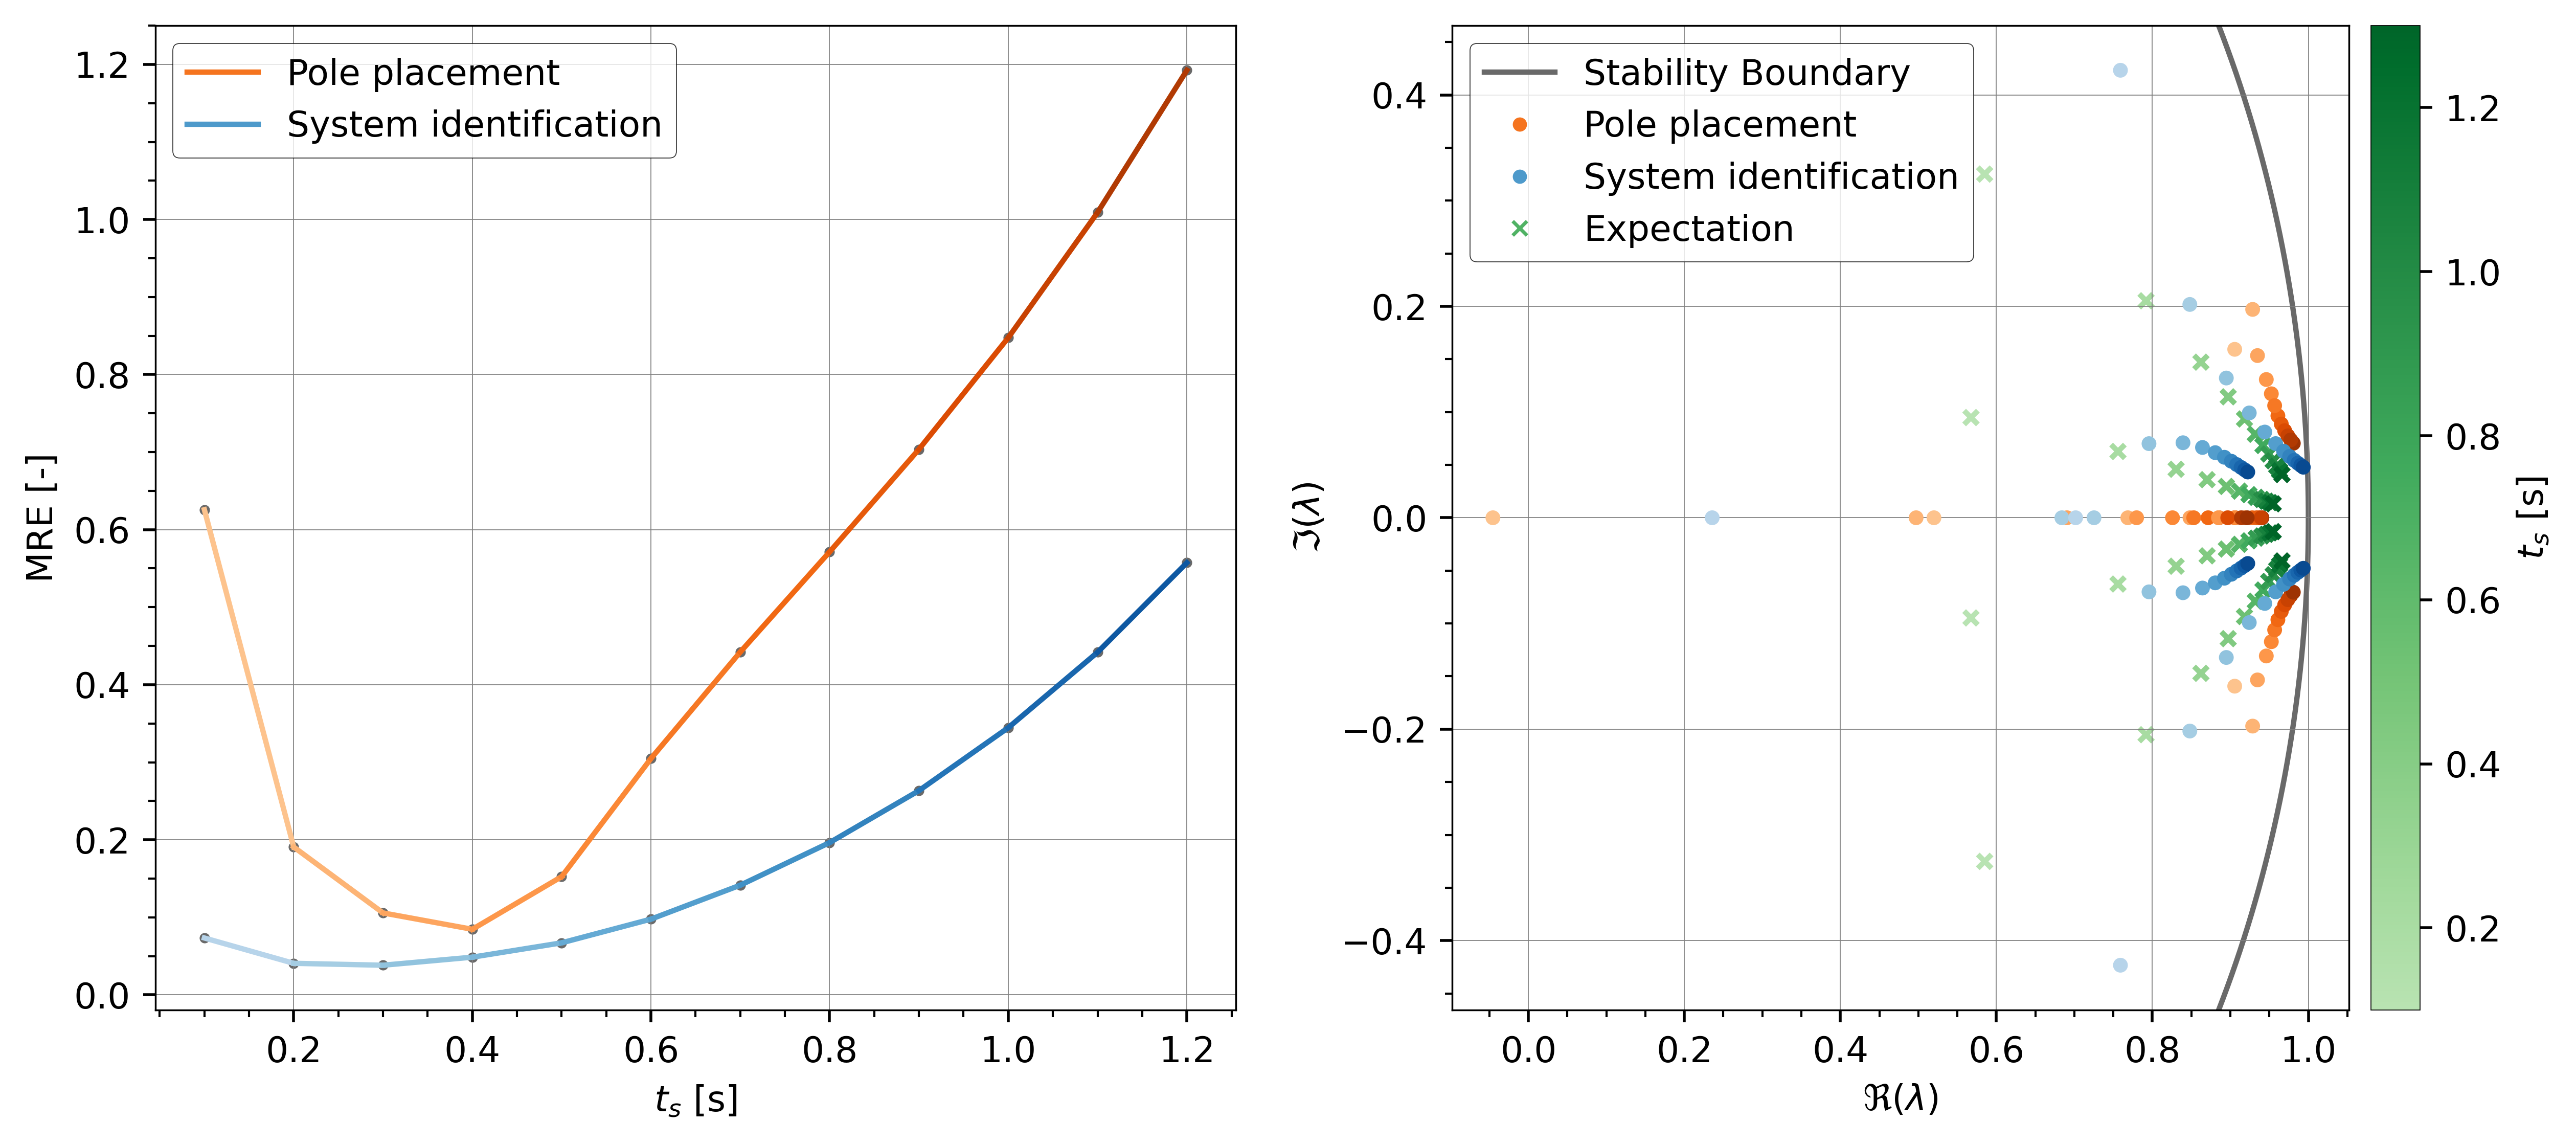

In [23]:
# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/WithExcitementPolesEvo.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)

# Initialize the poles_bessel array with the complex data type
poles_bessel = np.zeros((4, len(x)), dtype=complex)

for i in range(len(x)):
    # Desired poles
    tsdesired = x[i]
    pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
    poles_bessel[:, i] = np.exp(0.01 * pole)

for i in range(4):
    gradient_colors = get_color_gradient(colors2[2], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(poles_bessel[i]), np.imag(poles_bessel[i]), color=gradient_colors, marker="x", s=15)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('$t_s$ [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDSimulation/DataForPlot/WithExcitementPolesEvoPlot.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

# Add a colorbar to the second plot
sm = plt.cm.ScalarMappable(cmap=LinearSegmentedColormap.from_list('custom_gradient', np.array(plt.get_cmap(colors2[2])(range(int(256*0.3),int(256*0.9))))), norm=Normalize(vmin=0.1, vmax=1.3))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2, orientation='vertical', pad=0.02)
cbar.set_label('$t_s$ [s]')
# Customize the colorbar's outline properties
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(0.25)

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper left')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper left')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/ExcitementPoleChange.png", bbox_inches='tight')  
plt.show()

# 4. Experimentation


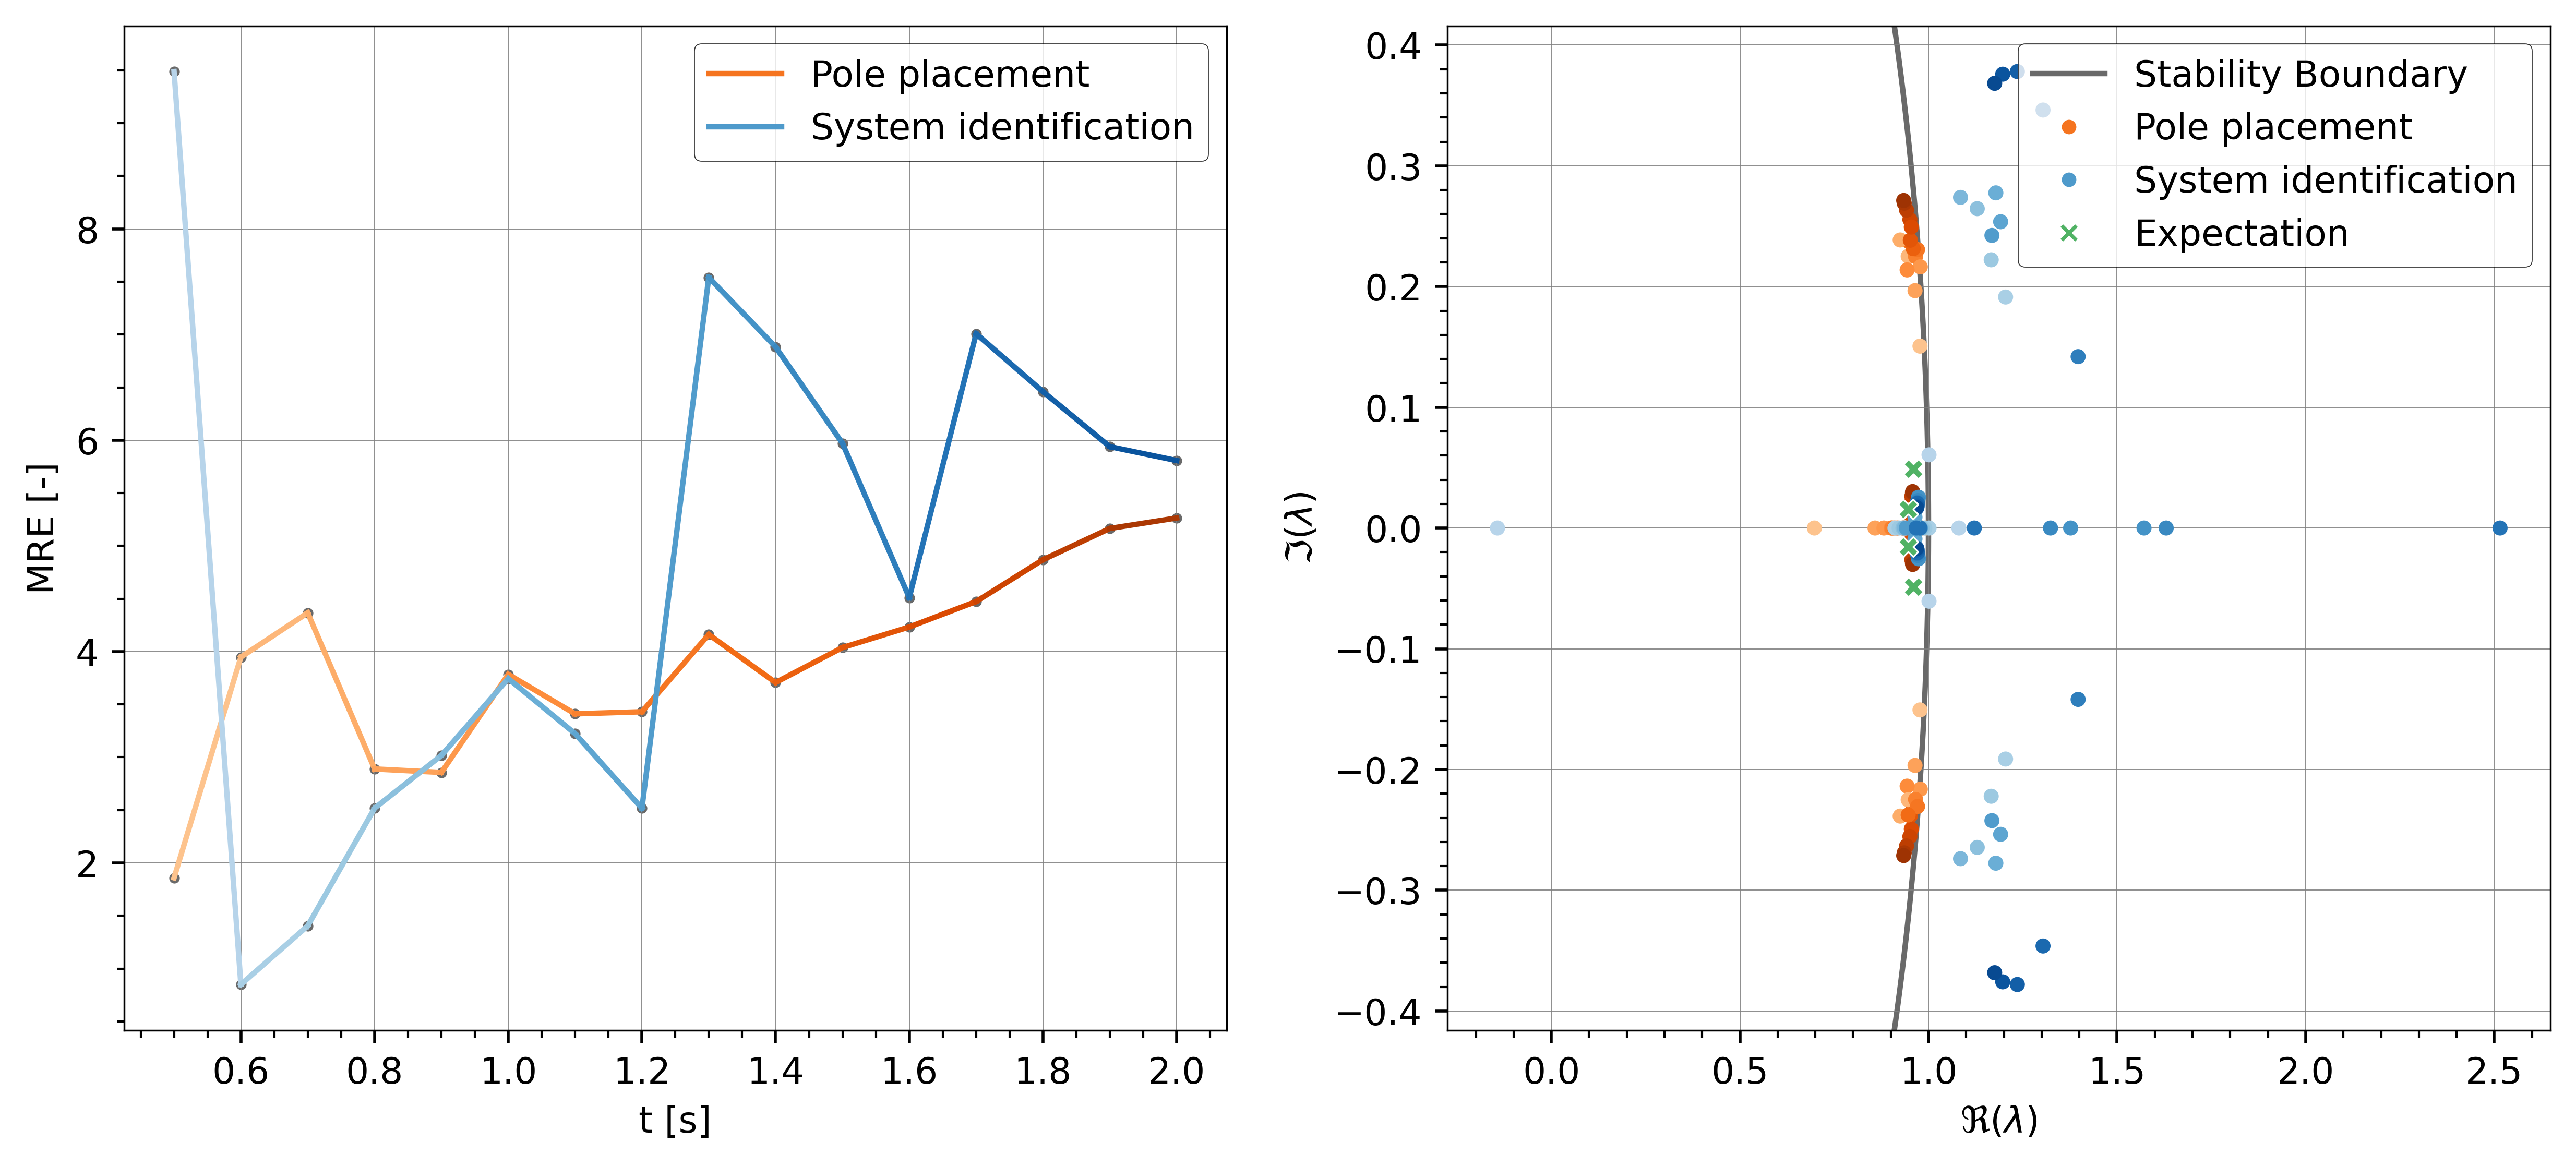

In [25]:
# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable1Plot.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
tsdesired = 1
pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
poles_bessel = np.exp(0.01 * pole)
sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('t [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable1Plotb.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper right')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper right')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/ExpeNoExcitement.png", bbox_inches='tight')  
plt.show()

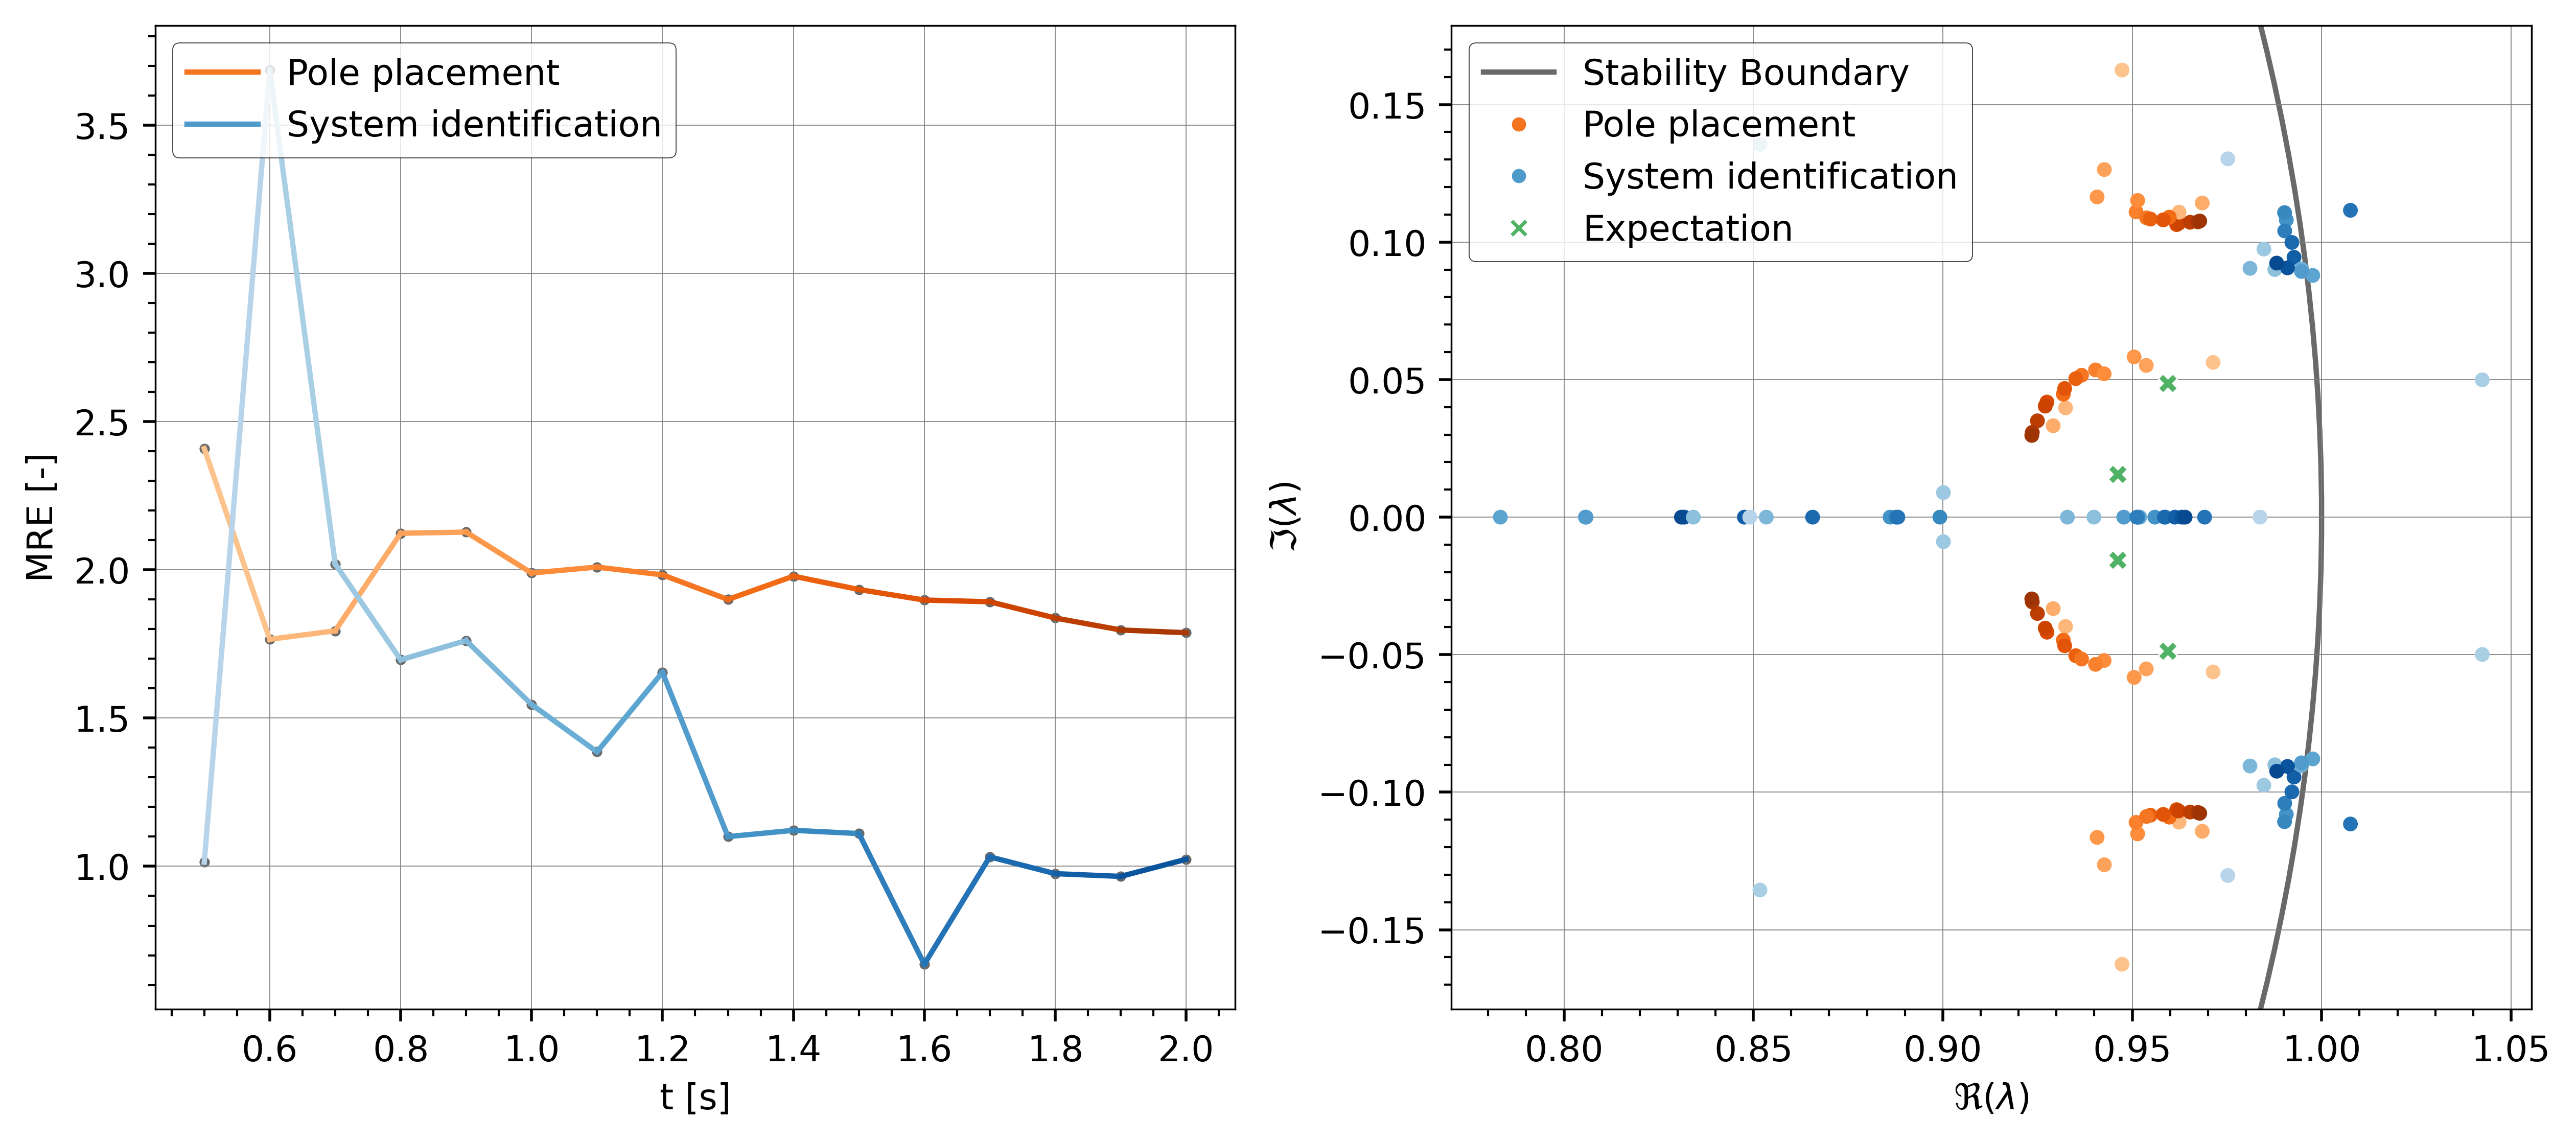

In [26]:
# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable2Plot.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
tsdesired = 1
pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
poles_bessel = np.exp(0.01 * pole)
sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('t [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable2Plotb.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper left')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper left')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/ExpeNoExcitementTest2.png", bbox_inches='tight')  
plt.show()

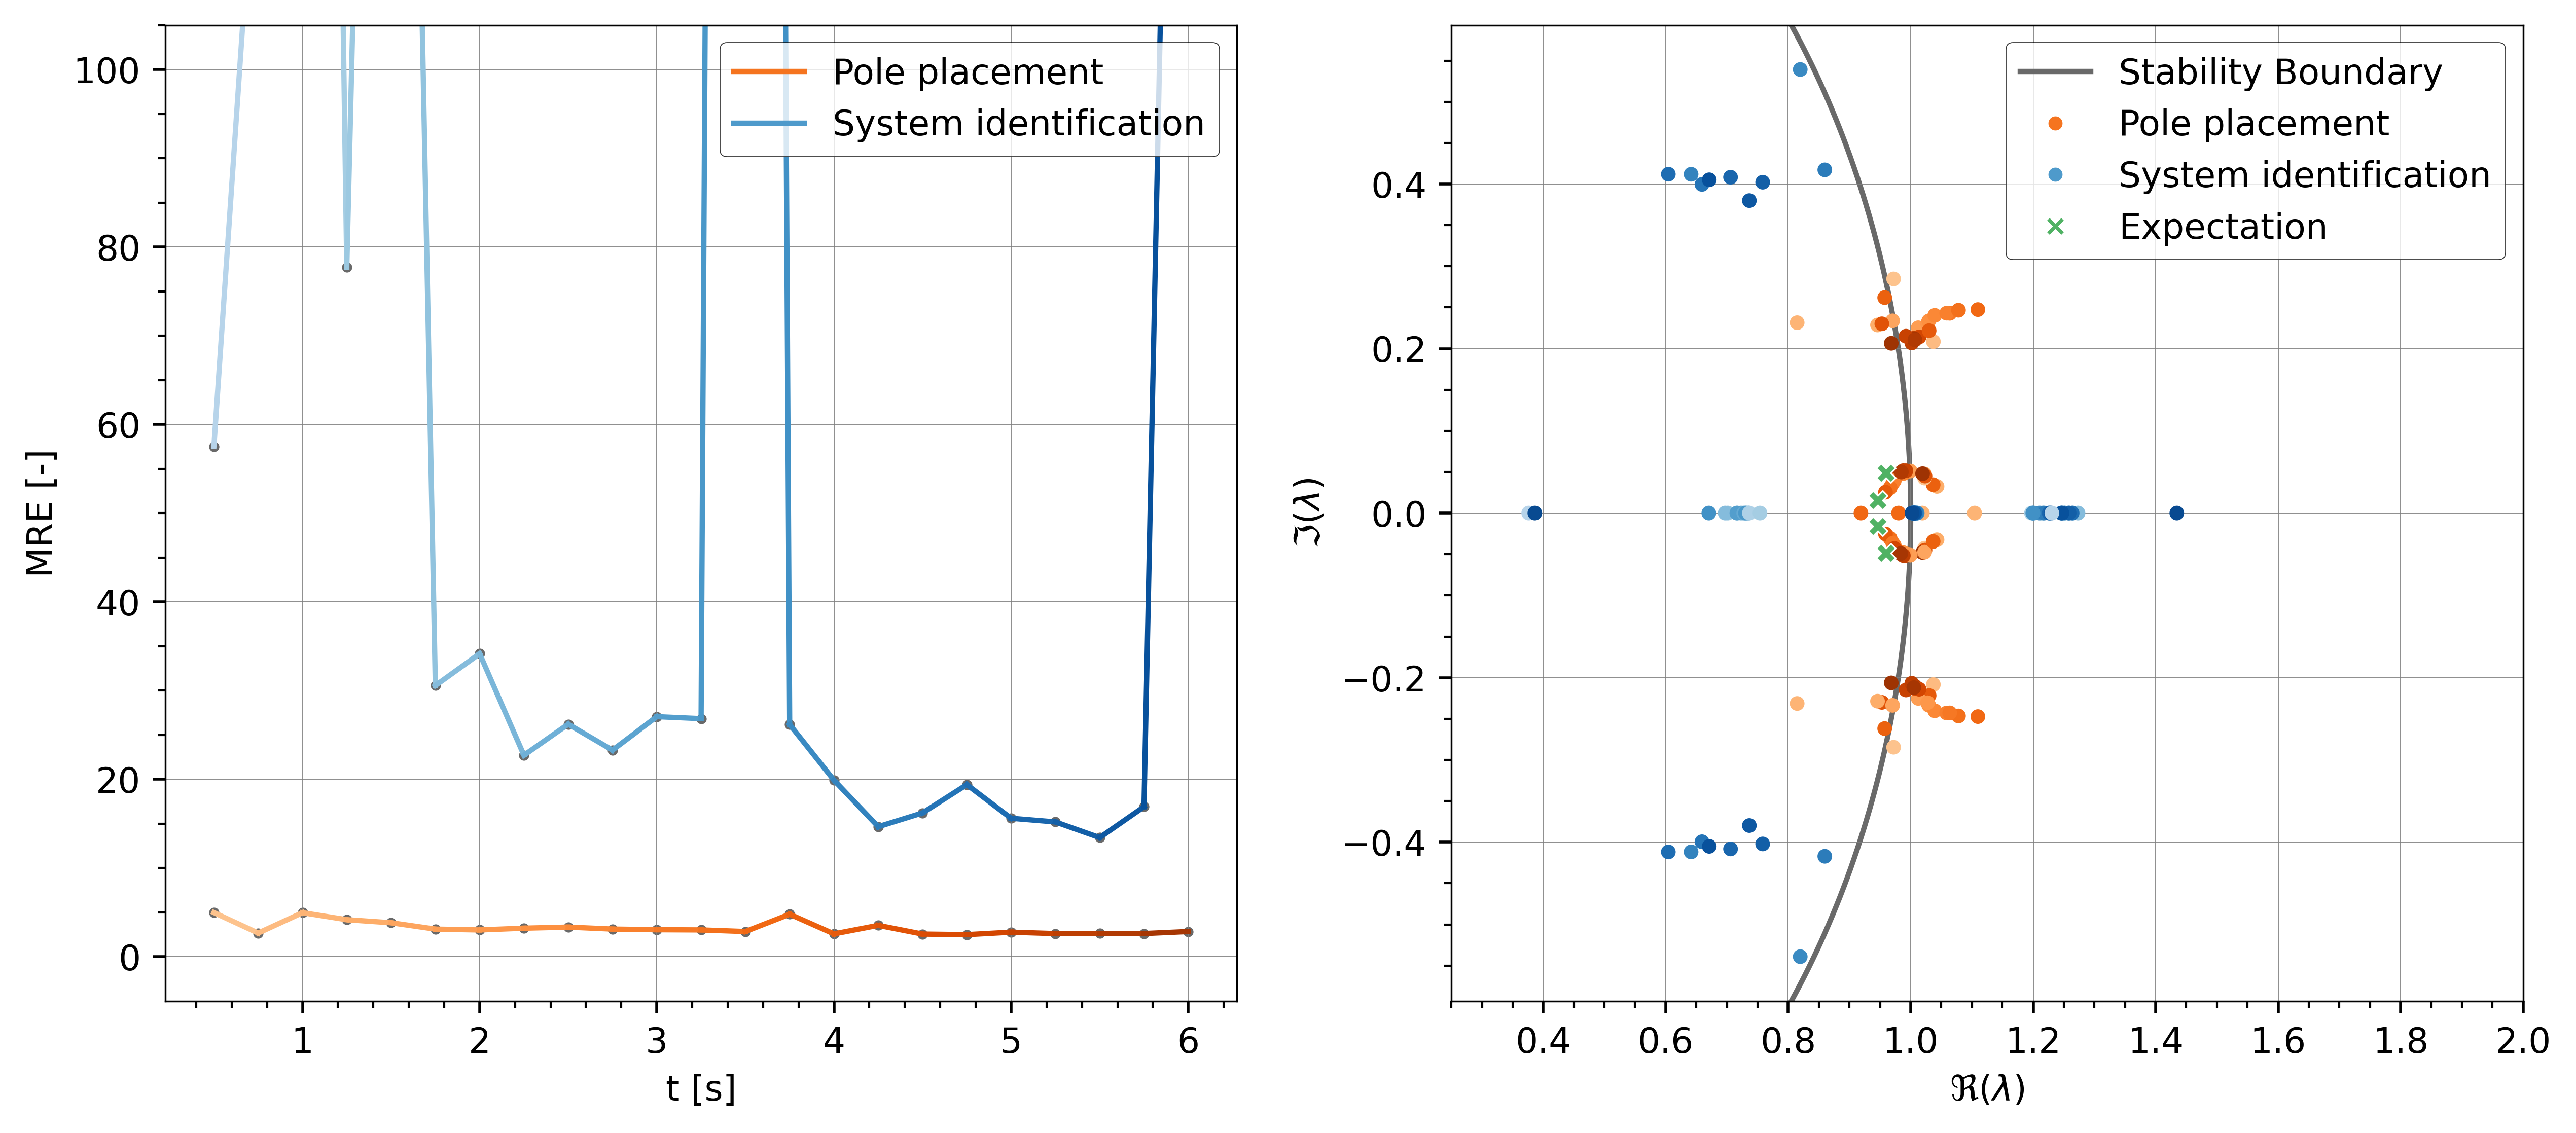

In [27]:
# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable2bPlot.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
tsdesired = 1
pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
poles_bessel = np.exp(0.01 * pole)
sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('t [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable2bPlotb.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper right')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper right')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax1.set_ylim(-5, 105)
ax2.set_ylim(ymin, ymax)
ax2.set_xlim(0.25, 2)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/ExpeNoExcitementTest3.png", bbox_inches='tight')  
plt.show()

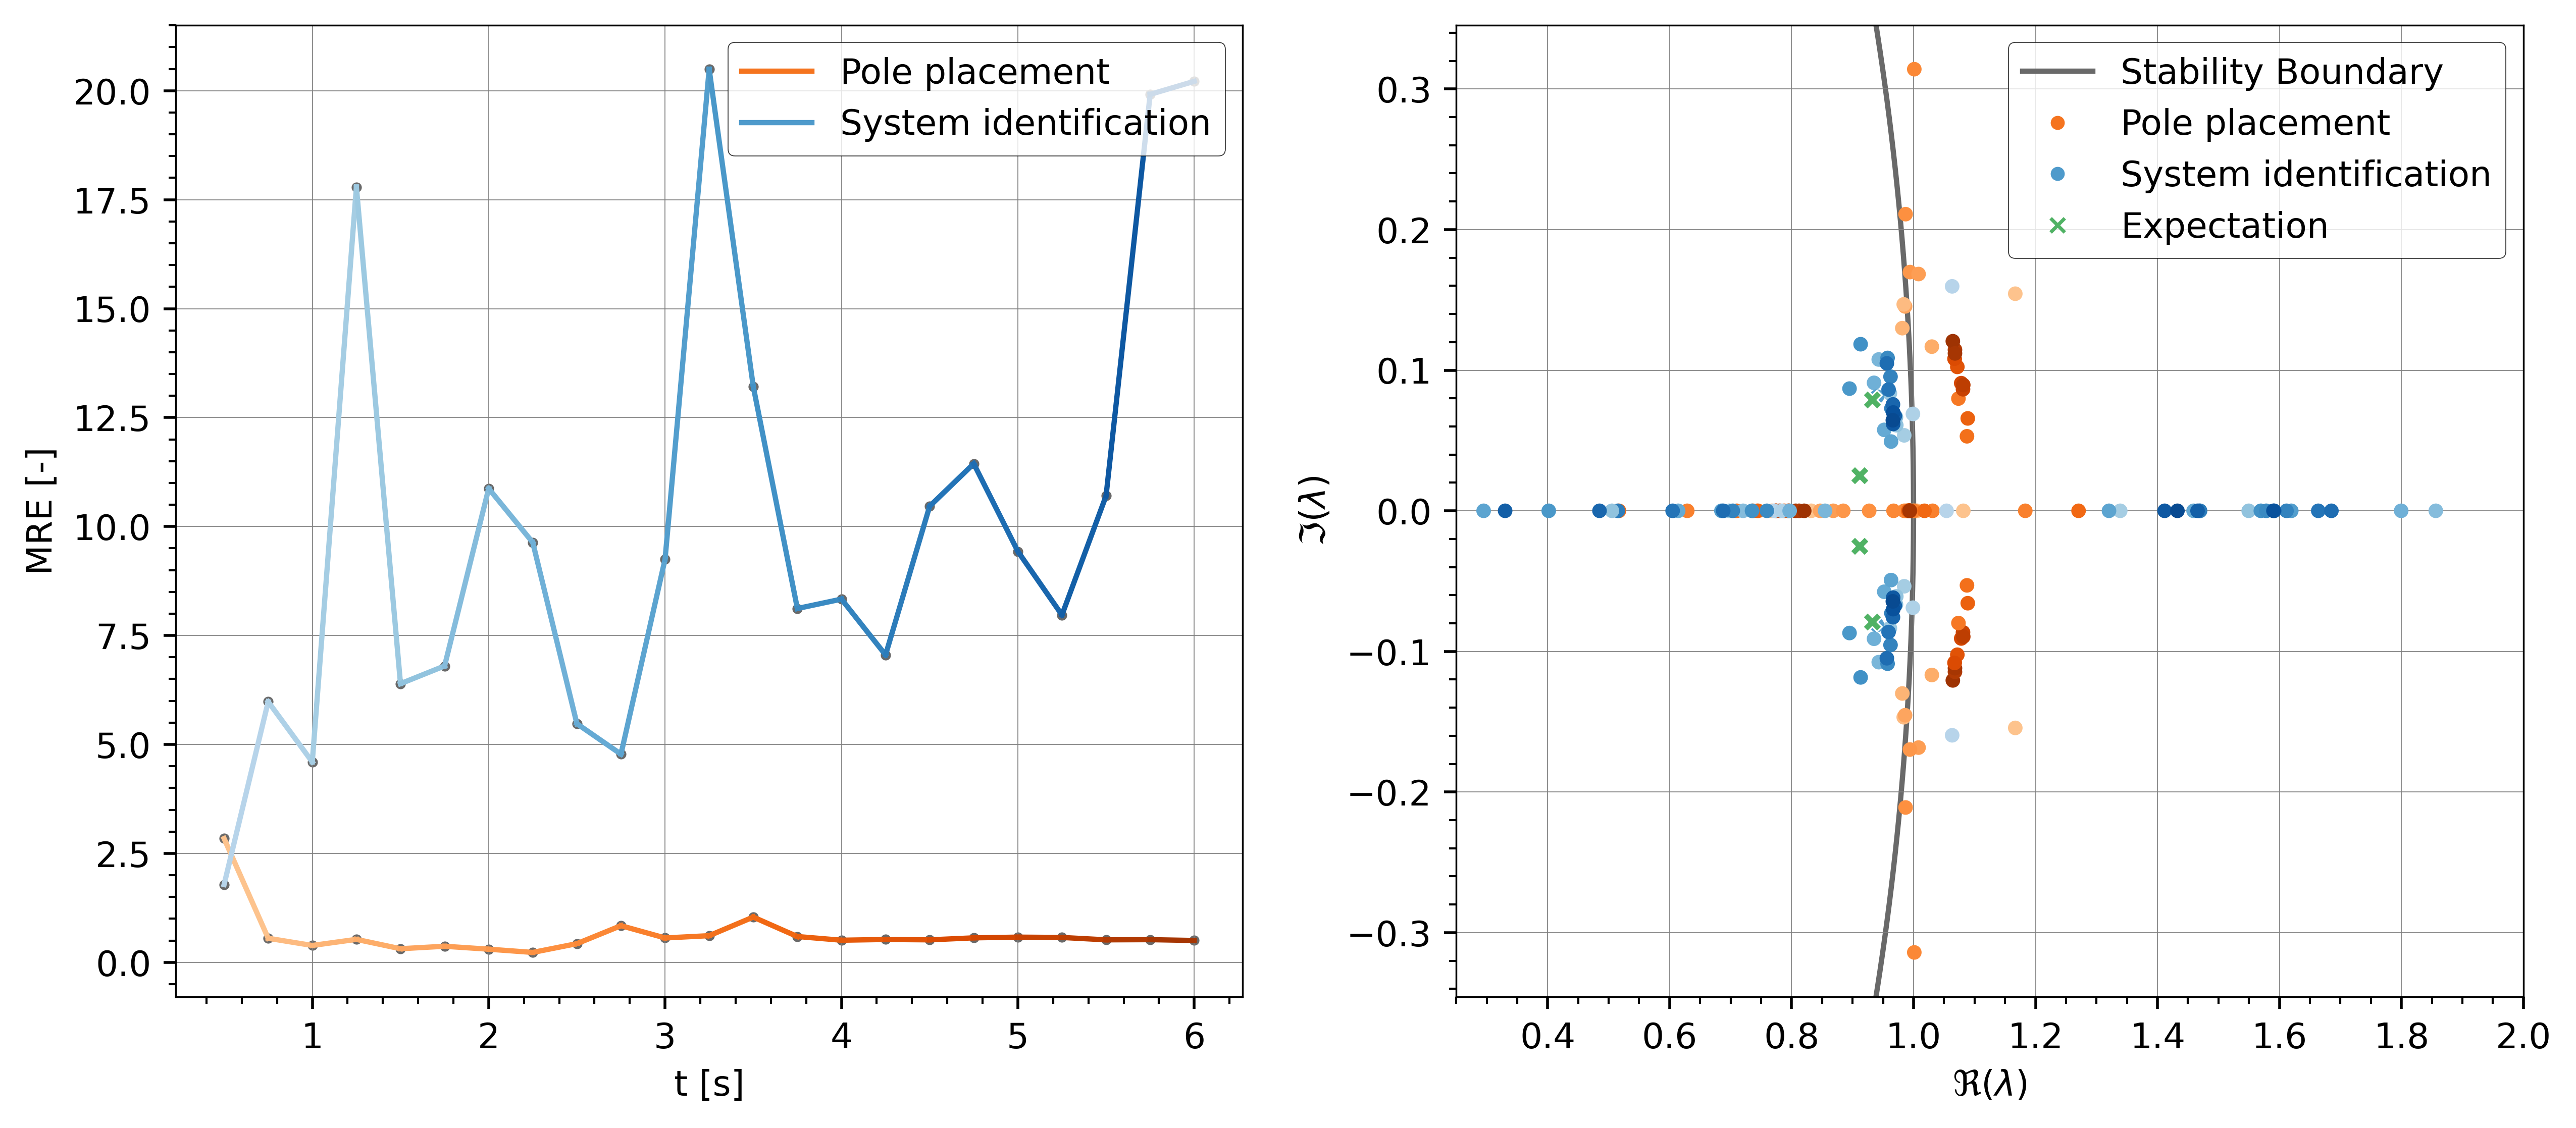

In [28]:
# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable3Plot.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
tsdesired = 0.6
pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
poles_bessel = np.exp(0.01 * pole)
sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('t [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable3Plotb.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper right')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper right')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
ax2.set_xlim(0.25, 2)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/ExpeWithExcitation.png", bbox_inches='tight')  
plt.show()

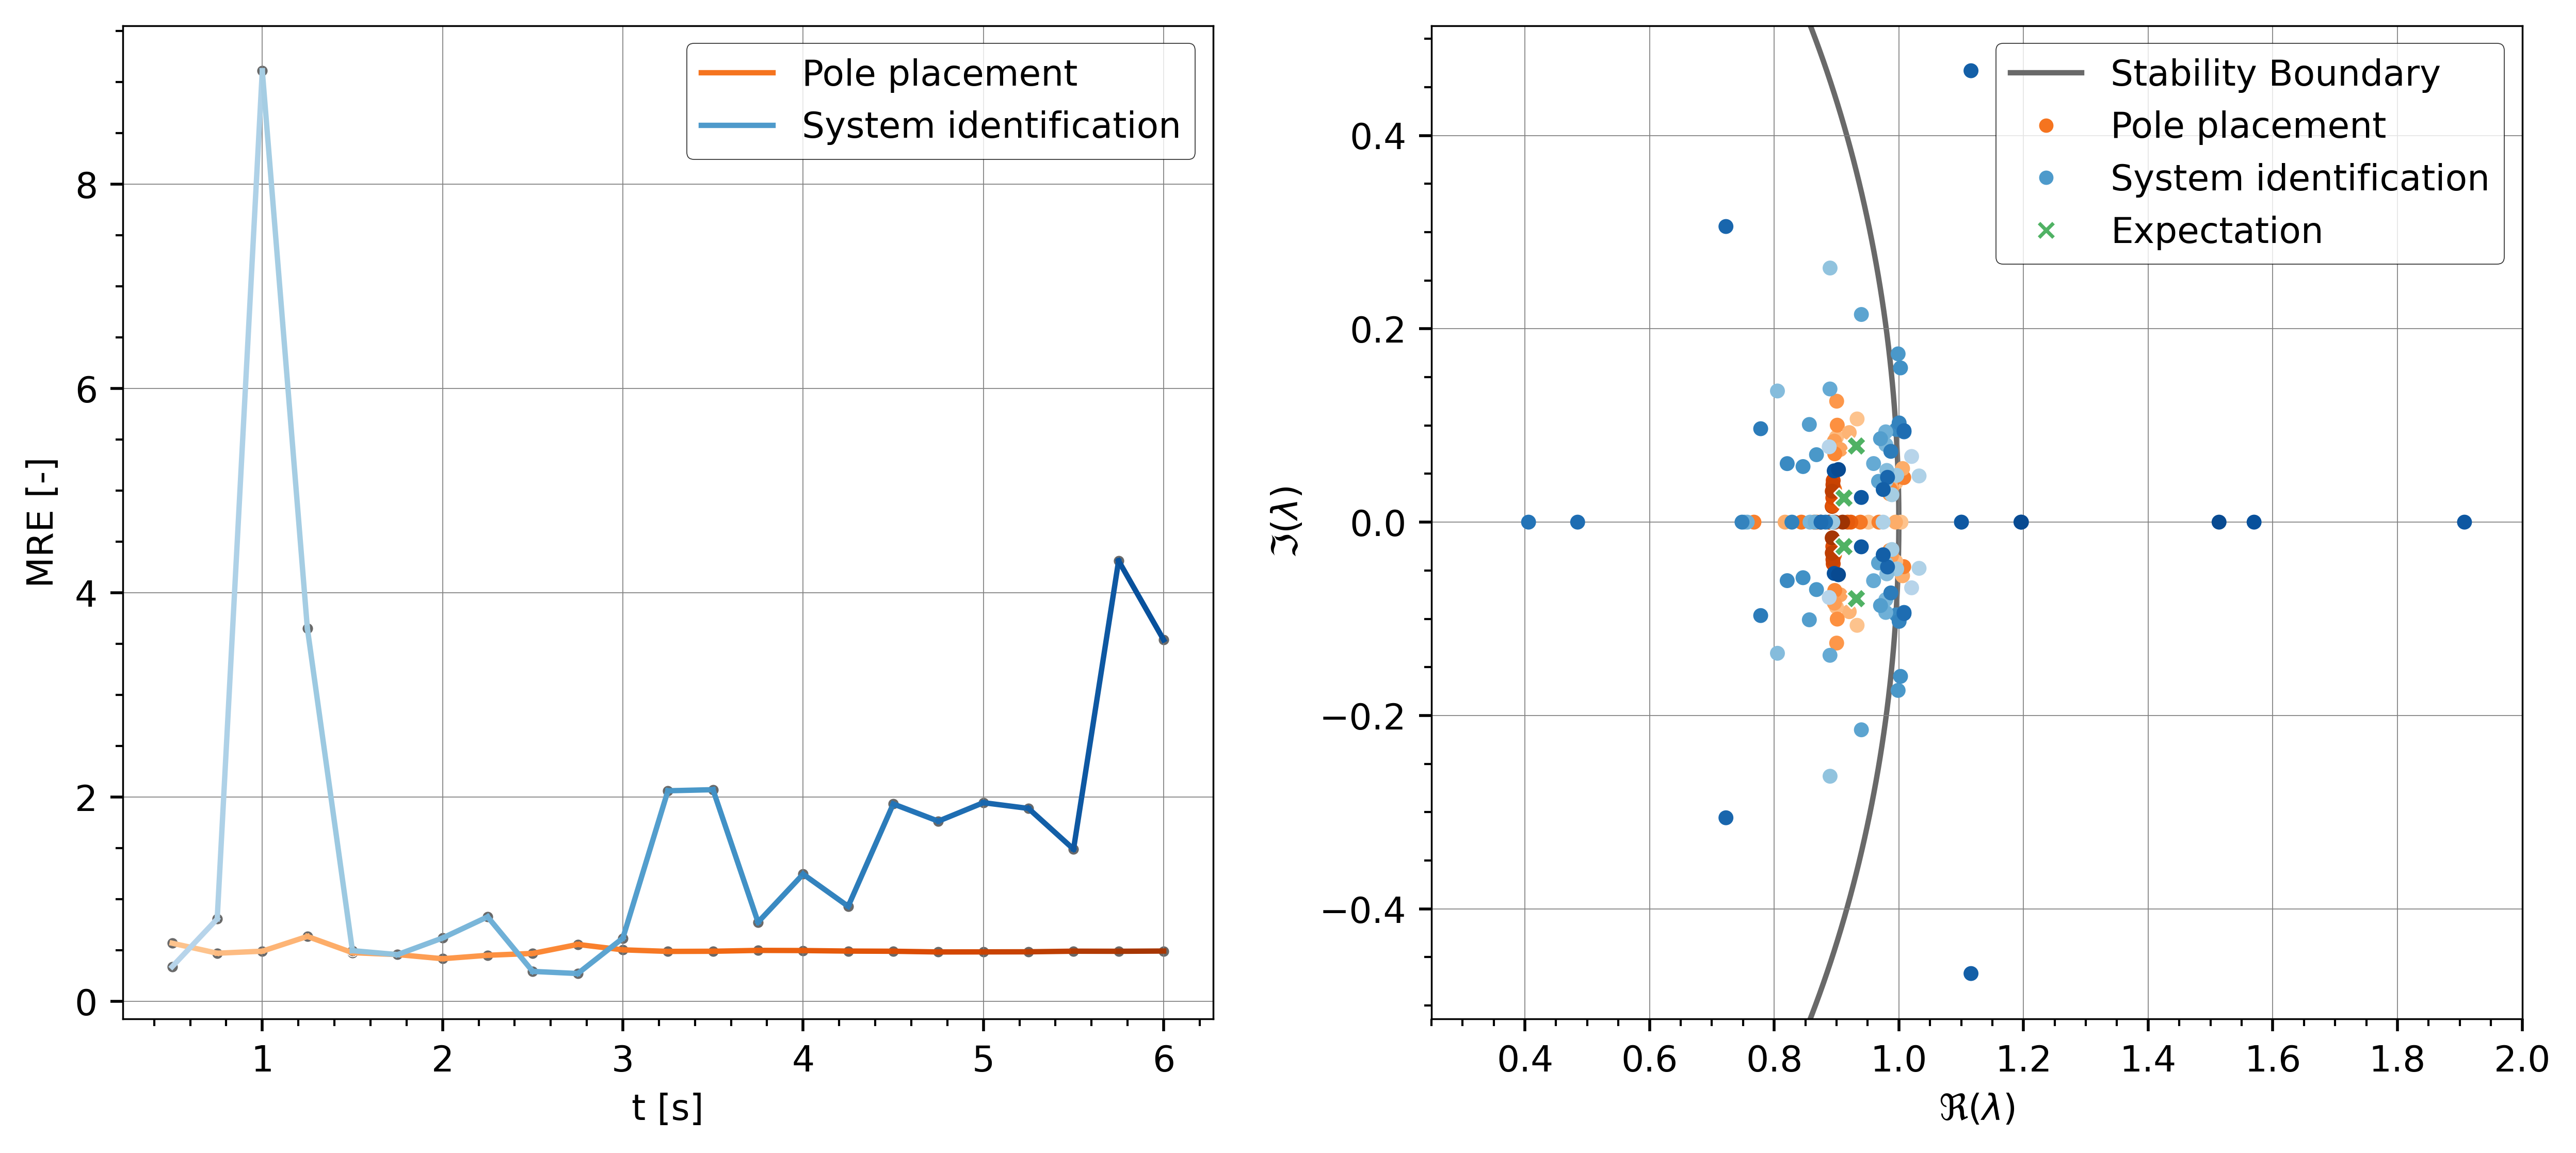

In [29]:
# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable4Plot.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
# Initialize the poles_bessel array with the complex data type
tsdesired = 0.6
pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
poles_bessel = np.exp(0.01 * pole)
sns.scatterplot(x=np.real(poles_bessel), y=np.imag(poles_bessel),ax=ax2, zorder=4, color=plt.get_cmap(colors2[2])(150), marker="X", s=30)

#sns.scatterplot(x=np.real(poles_bessel1), y=np.imag(poles_bessel1), ax=ax2,label='MB', color=gradient_colors, marker="X", s=20)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('t [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable4Plotb.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper right')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper right')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
ax2.set_xlim(0.25, 2)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/ExpeWithExcitationTest2.png", bbox_inches='tight')  
plt.show()

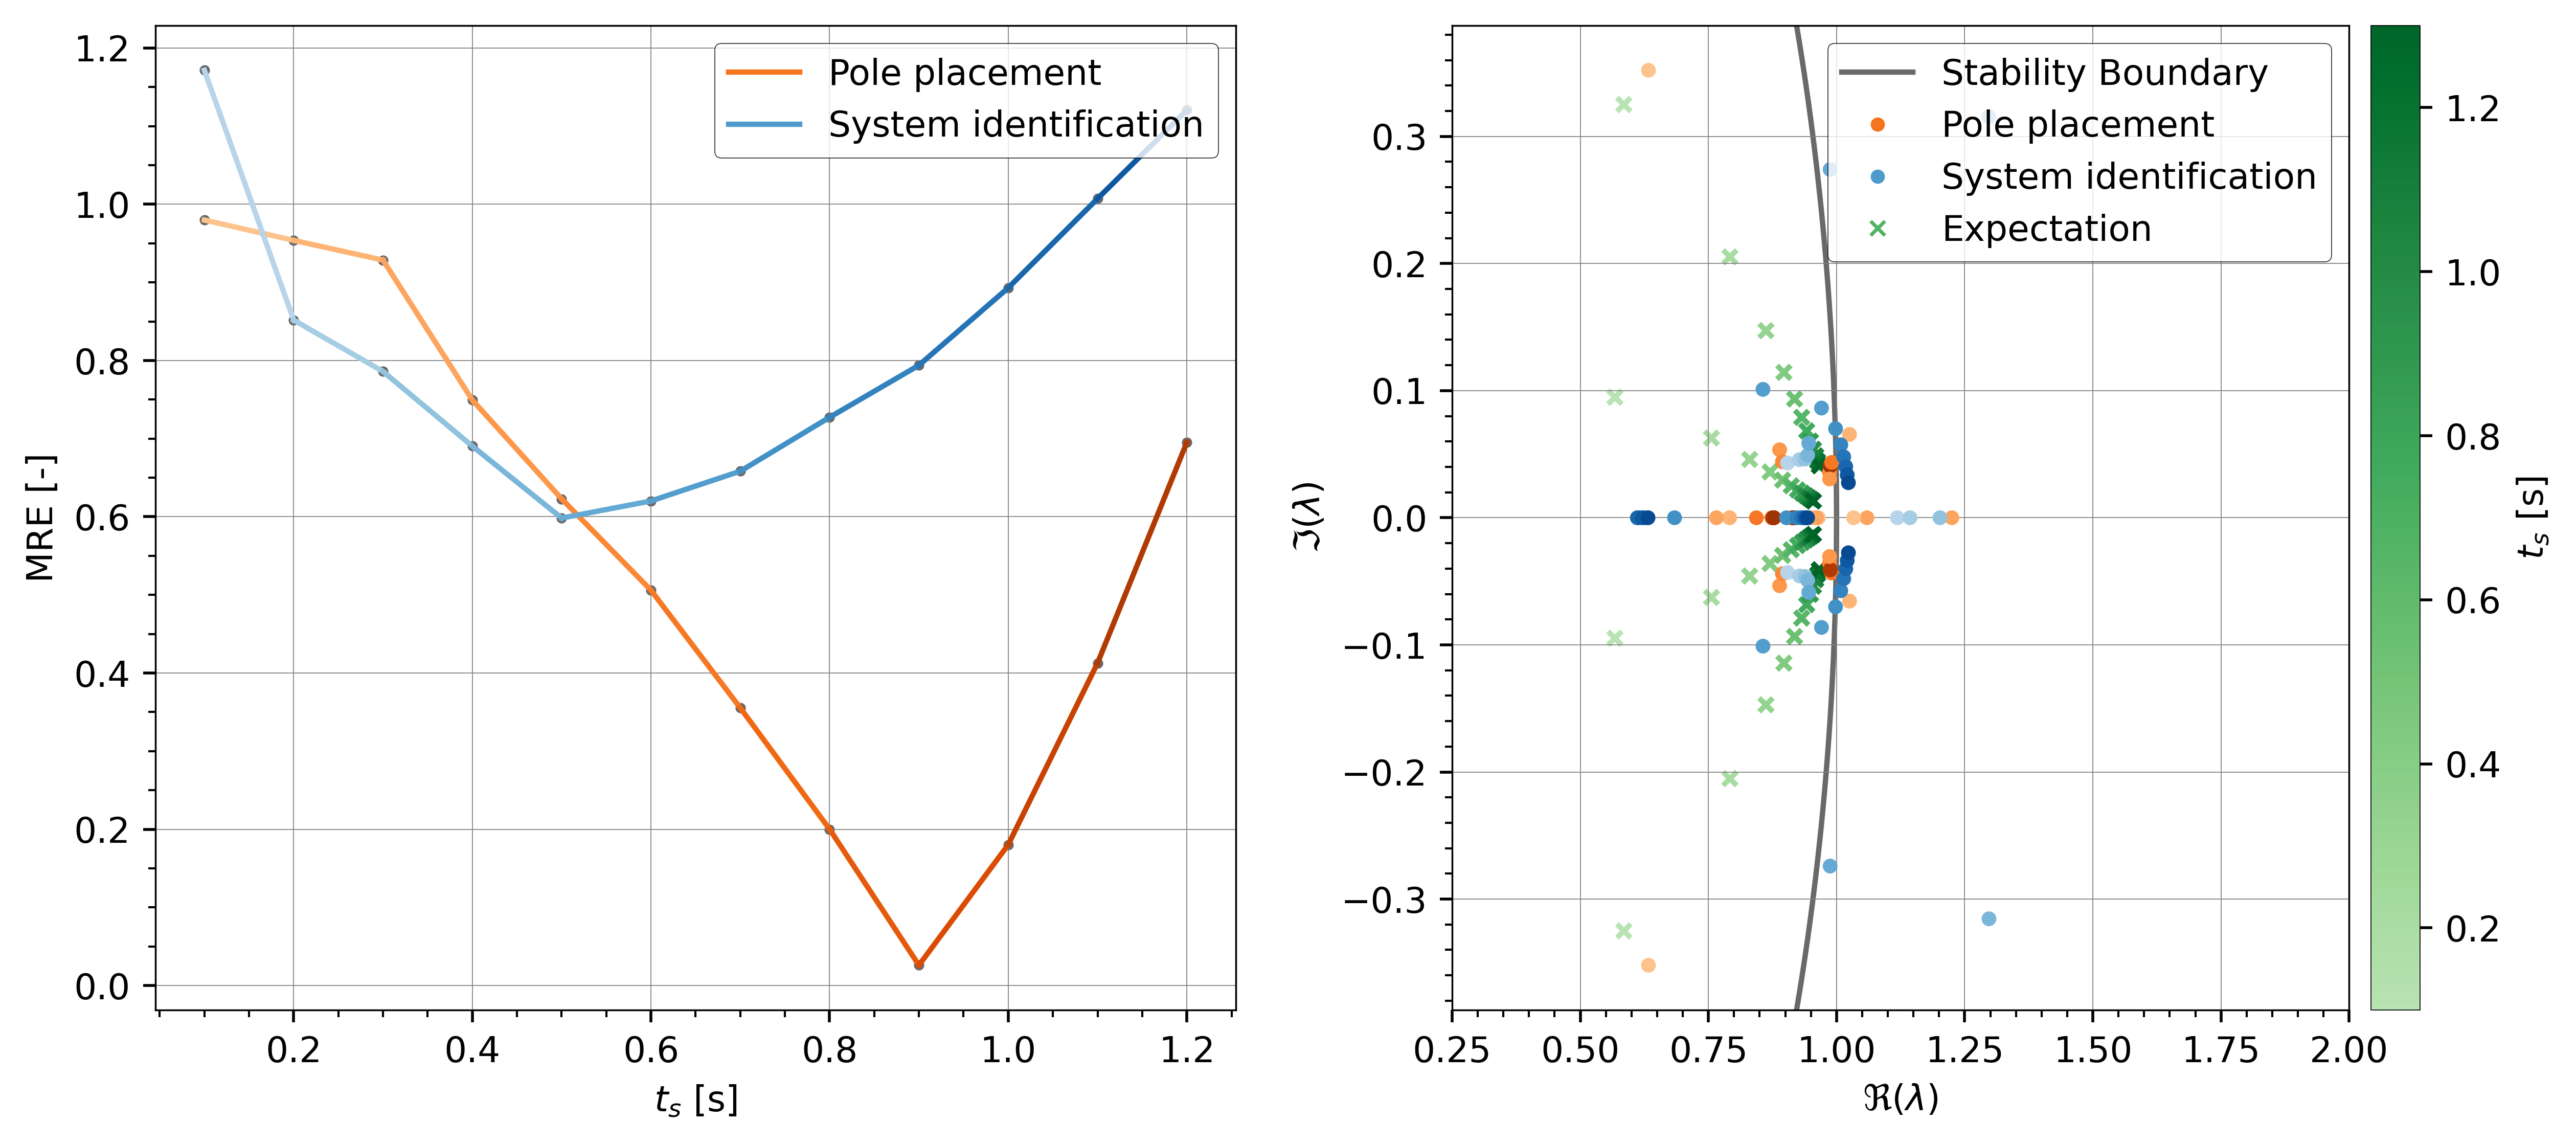

In [30]:
# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable5Plot.csv')

# Extract x and y values
x = data.x
y1 = data.y1
y2 = data.y2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)

# Initialize the poles_bessel array with the complex data type
poles_bessel = np.zeros((4, len(x)), dtype=complex)

for i in range(len(x)):
    # Desired poles
    tsdesired = x[i]
    pole = np.array([-4.016+5.072j, -4.016-5.072j, -5.528+1.655j, -5.528-1.655j]) / tsdesired
    poles_bessel[:, i] = np.exp(0.01 * pole)

for i in range(4):
    gradient_colors = get_color_gradient(colors2[2], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(poles_bessel[i]), np.imag(poles_bessel[i]), color=gradient_colors, marker="x", s=15)


gradient_colors = get_color_gradient(colors2[0], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y1[j:j+2], color=gradient_colors[j], linewidth=1.5)

#sns.lineplot(x=x1, y=y1, ax=ax1, label='PP', color=colors[0], linewidth=1.5)

sns.scatterplot(x=x, y=y1, ax=ax1, color='dimgray', marker="o", s=10)

gradient_colors = get_color_gradient(colors2[1], len(x))
for j in range(len(x)):
    ax1.plot(x[j:j+2], y2[j:j+2], color=gradient_colors[j], linewidth=1.5)

sns.scatterplot(x=x, y=y2, ax=ax1, color='dimgray', marker="o", s=10)

ax1.set_xlabel('$t_s$ [s]')
ax1.set_ylabel('MRE [-]')

# Load data from CSV files
data = pd.read_csv('DDExperimental/DataForPlot/NoExcitementVariable5Plotb.csv')
# Extract x and y values
x = data['x']
y1 = [data['p11'].apply(str_to_complex), data['p12'].apply(str_to_complex), data['p13'].apply(str_to_complex), data['p14'].apply(str_to_complex)]
y2 = [data['p21'].apply(str_to_complex), data['p22'].apply(str_to_complex), data['p23'].apply(str_to_complex), data['p24'].apply(str_to_complex)]

# Plotting y1 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[0], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y1[i][j:j+2]), np.imag(y1[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y1[i]), np.imag(y1[i]), zorder=2, color=gradient_colors, marker="o", s=10)

# Plotting y2 with color gradient
for i in range(4):
    gradient_colors = get_color_gradient(colors2[1], len(x))
    #for j in range(maxData - 1):
        #plt.plot(np.real(y2[i][j:j+2]), np.imag(y2[i][j:j+2]), color=gradient_colors[j], linewidth=0.75)
    ax2.scatter(np.real(y2[i]), np.imag(y2[i]), zorder=3, color=gradient_colors, marker="o", s=10)

# Plot 2
ax2.set_xlabel('$\Re(\lambda)$')
ax2.set_ylabel('$\Im(\lambda)$')

# Add a colorbar to the second plot
sm = plt.cm.ScalarMappable(cmap=LinearSegmentedColormap.from_list('custom_gradient', np.array(plt.get_cmap(colors2[2])(range(int(256*0.3),int(256*0.9))))), norm=Normalize(vmin=0.1, vmax=1.3))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2, orientation='vertical', pad=0.02)
cbar.set_label('$t_s$ [s]')
# Customize the colorbar's outline properties
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(0.25)

legend_handles1 = [
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), linestyle='-', linewidth=1.5, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), linestyle='-', linewidth=1.5, label='System identification'),
]
legend_handles2 = [
    mlines.Line2D([], [], color='dimgray', linestyle='-', linewidth=1.5, label='Stability Boundary'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[0])(150), marker='.', linestyle='None', markersize=6, label='Pole placement'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[1])(150), marker='.', linestyle='None', markersize=6, label='System identification'),
    mlines.Line2D([], [], color=plt.get_cmap(colors2[2])(150), marker='x', linestyle='None', markersize=4, label='Expectation')
]

legend1 = ax1.legend(handles=legend_handles1, frameon=True, loc='upper right')
legend2 = ax2.legend(handles=legend_handles2, frameon=True, loc='upper right')

legend_frame = legend1.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

legend_frame = legend2.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)  # Change the box's border width

# Customizing plot borders and other settings for each subplot
for ax in (ax1,ax2):
    # Customizing axes and plot border
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    # Setting the style for grid lines
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')
    ax.minorticks_on()  # Turn on minor ticks
# Get the current y-axis limits
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()

# Generate points for the unit circle
theta = np.linspace(-np.pi, np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

# Mask points that are outside the current y-axis limits
mask = (unit_circle_x >= xmin) & (unit_circle_x <= xmax) & (unit_circle_y >= ymin-0.1) & (unit_circle_y <= ymax+0.1)
ax2.set_ylim(ymin, ymax)
ax2.set_xlim(0.25, 2)
# Plot the part of the unit circle within the current y-axis limits
ax2.plot(unit_circle_x[mask], unit_circle_y[mask], zorder=1, linestyle='-', color='dimgray', linewidth=1.5)

#plt.tight_layout()
plt.savefig("plot/FinalPlot.png", bbox_inches='tight')  
plt.show()